# Import Libraries

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib


In [209]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from scipy.stats import loguniform

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from torchinfo import summary
from torchmetrics.regression import MeanAbsoluteError
from  pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

import os
import json
import sklearn

In [210]:
# Had to "pip install openpyxl"
!pip install openpyxl
dataset = pd.read_excel("pr11_credit_scores.xlsx")


# EDA

In [211]:
dataset.info()

# The fact that we have some variables as objects, when they should be strings or numbers, points us to the fact that there are sveral data types mixed together (which should not happen) and alter us to data cleaningdataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       99909 non-null   object 
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             99909 non-null   object 
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               99909 non-null   object 
 13  Type_of_Loan              88509 non-null   ob

In [212]:
dataset.describe(include="all")

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,99909.0,99909,99909,99909,84920.000000,99909.000000,99909.000000,99909.000000,99909.0,88509,100000.000000,92998.0,100000,98035.000000,100000,100000,100000.000000,90970,100000,100000.000000,95521,100000,98800,100000
unique,100000,12500,44,10139,1799.0,12501,31,18936,NaN,NaN,NaN,NaN,434.0,6260,NaN,762.0,4384,NaN,4,13178,NaN,404,3,NaN,91049,13,98792,3
top,0x1602,CUS_0xd40,August,Langep,38.0,#F%$D@*&8,_______,17273.83,NaN,NaN,NaN,NaN,3.0,Not Specified,NaN,19.0,_,NaN,Standard,1360.45,NaN,15 Years and 11 Months,Yes,NaN,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12384,44,2831.0,5565,7055,16,NaN,NaN,NaN,NaN,14368.0,1406,NaN,5327.0,2091,NaN,36479,24,NaN,446,52326,NaN,4305,25487,9,53174
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4194.071131,17.104395,22.495621,72.469027,NaN,NaN,21.068780,NaN,NaN,27.754251,NaN,NaN,32.285173,NaN,NaN,1403.118217,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3183.605038,117.454091,129.115463,466.383442,NaN,NaN,14.860104,NaN,NaN,193.177339,NaN,NaN,5.116875,NaN,NaN,8306.041270,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.645417,-1.000000,0.000000,1.000000,NaN,NaN,-5.000000,NaN,NaN,0.000000,NaN,NaN,20.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1625.597917,3.000000,4.000000,8.000000,NaN,NaN,10.000000,NaN,NaN,3.000000,NaN,NaN,28.052567,NaN,NaN,30.306660,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.745000,6.000000,5.000000,13.000000,NaN,NaN,18.000000,NaN,NaN,6.000000,NaN,NaN,32.305784,NaN,NaN,69.249473,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5957.448333,7.000000,7.000000,20.000000,NaN,NaN,28.000000,NaN,NaN,9.000000,NaN,NaN,36.496663,NaN,NaN,161.224249,NaN,NaN,NaN,NaN


In [213]:
pd.set_option('display.max_columns', None)
dataset.head(24)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4,9.27,4.0,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8_,11.27,4.0,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good
7,0x1609,CUS_0xd40,August,NaN,23,#F%$D@*&8,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,6,11.27,4.0,Good,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28_,004-07-5839,_______,34847.84,3037.986667,2.0,4.0,6.0,1,Credit-Builder Loan,3,4,5.42,2.0,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825168246,Low_spent_Small_value_payments,470.69062692529184,Standard
9,0x160f,CUS_0x21b1,February,Rick Rothackerj,28,004-07-5839,Teacher,34847.84,3037.986667,2.0,4.0,6.0,1,Credit-Builder Loan,7,1,7.42,2.0,Good,605.03,38.550848,26 Years and 8 Months,No,18.816215,40.39123782853101,High_spent_Large_value_payments,484.5912142650067,Good


In [214]:
# By looking at the variables in the dataset and which type of variables they should be, we know that faulty values present in columns that do not match their data type cause the data type of the column to be off. The objective of this cell is to identify which type of columns we should have and set them straight.

categorical_variables = ["ID", "Customer_ID", "Month", "Name", "SSN", "Occupation", "Type_of_Loan", "Credit_Mix", "Credit_History_Age", "Payment_of_Min_Amount", "Payment_Behaviour", "Credit_Score"]
numerical_variables = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt", "Credit_Utilization_Ratio", "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"]


for column in dataset.columns:
    if column in categorical_variables and dataset[column].dtype not in ["object", "category"]:
        dataset[column] = dataset[column].astype("str").astype("category")
    elif column in numerical_variables and dataset[column].dtype not in ["float64", "int64"]:
        dataset[column] = pd.to_numeric(dataset[column], errors="coerce")



In [215]:
# We now see that variables are in the correct data type that correspnds to them 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       94974 non-null   float64
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             92932 non-null   float64
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               95127 non-null   float64
 13  Type_of_Loan              88509 non-null   ob

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


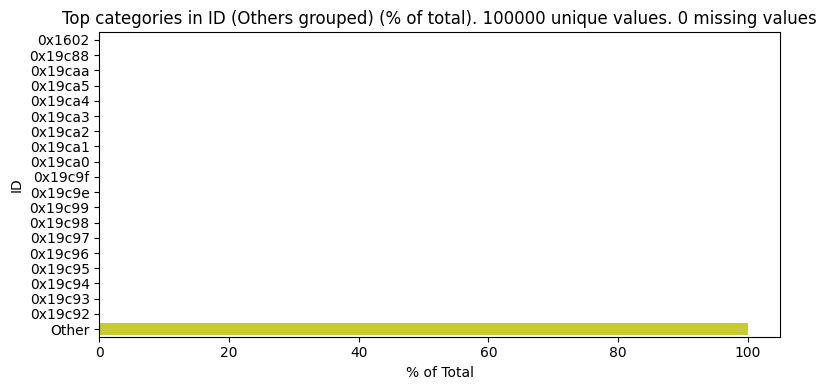

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


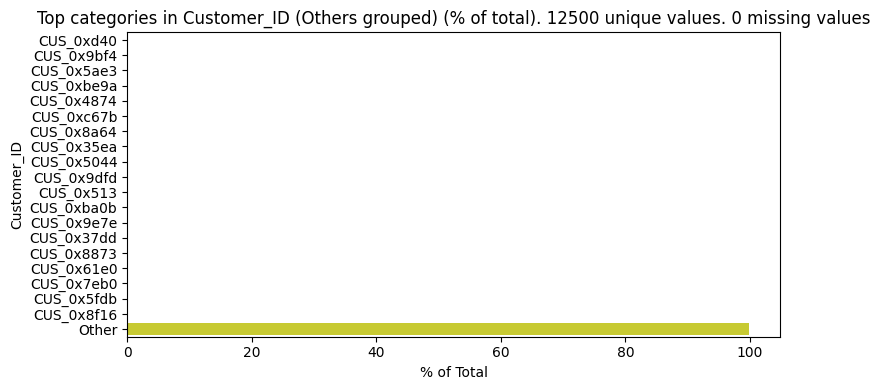

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


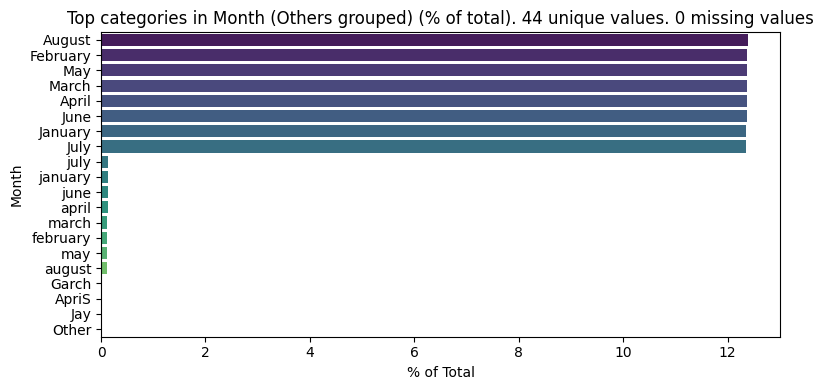

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


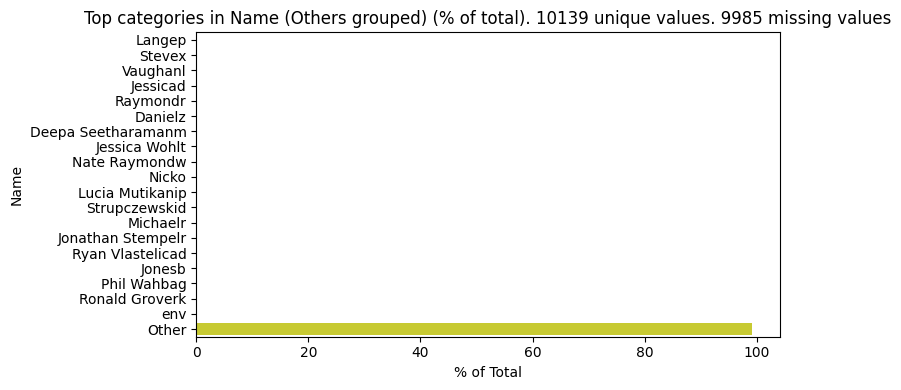

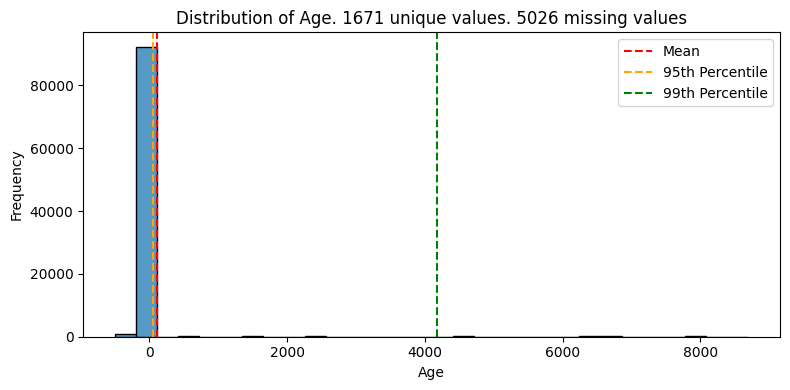

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


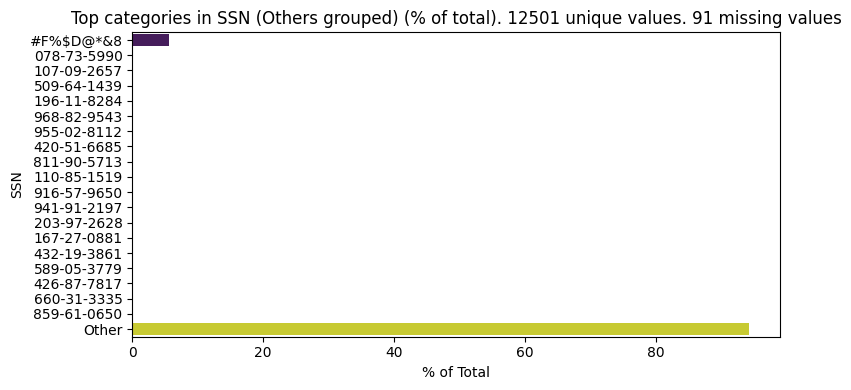

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


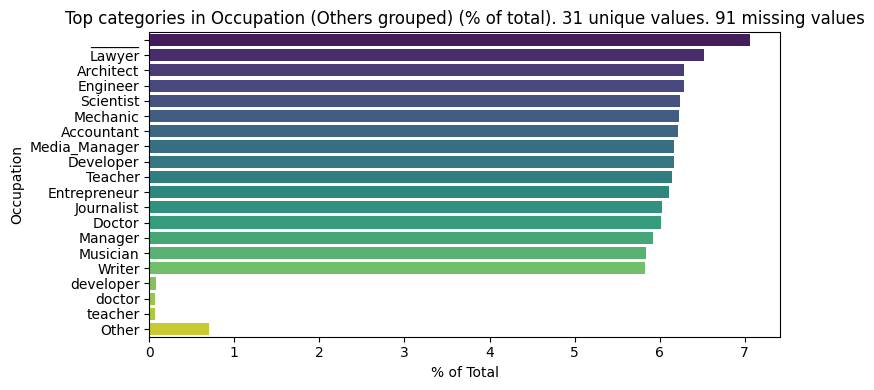

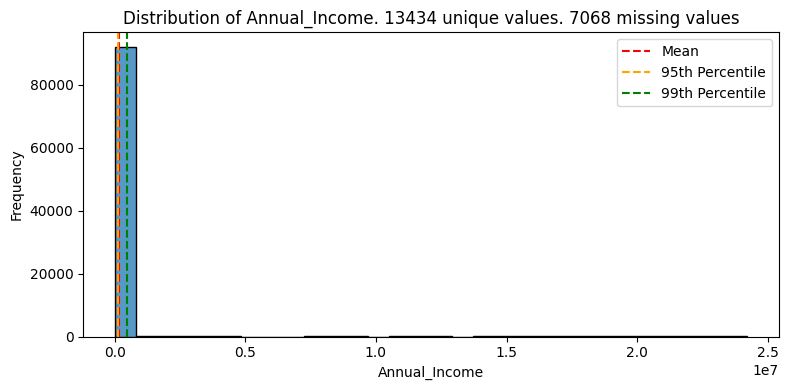

<Figure size 640x480 with 0 Axes>

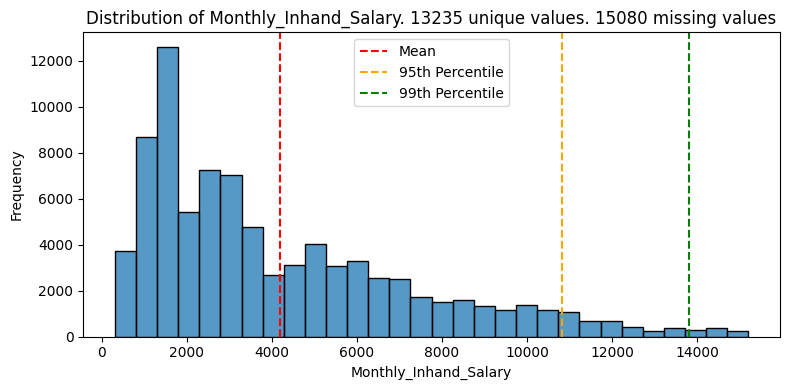

<Figure size 640x480 with 0 Axes>

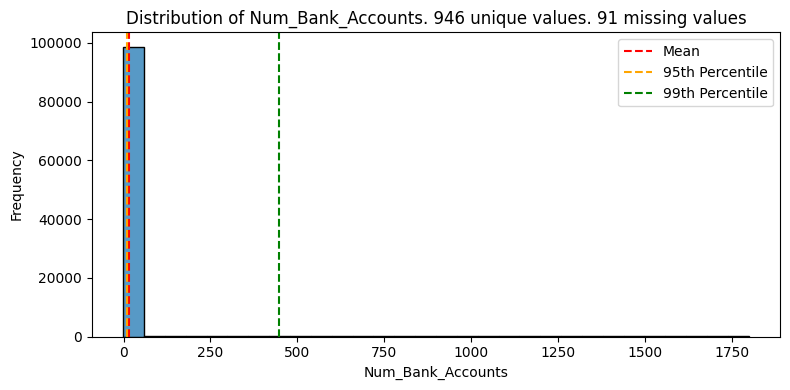

<Figure size 640x480 with 0 Axes>

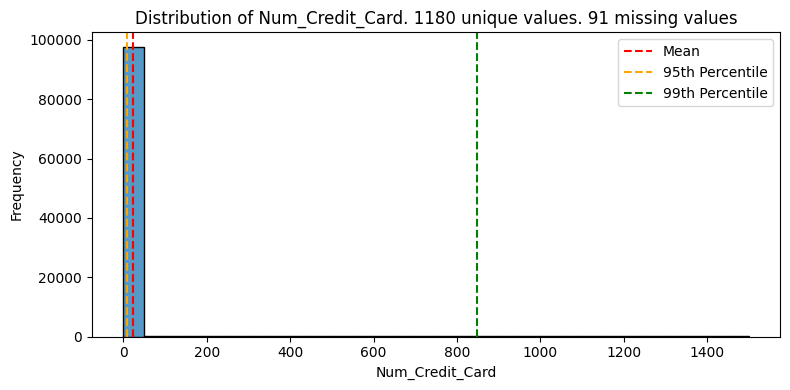

<Figure size 640x480 with 0 Axes>

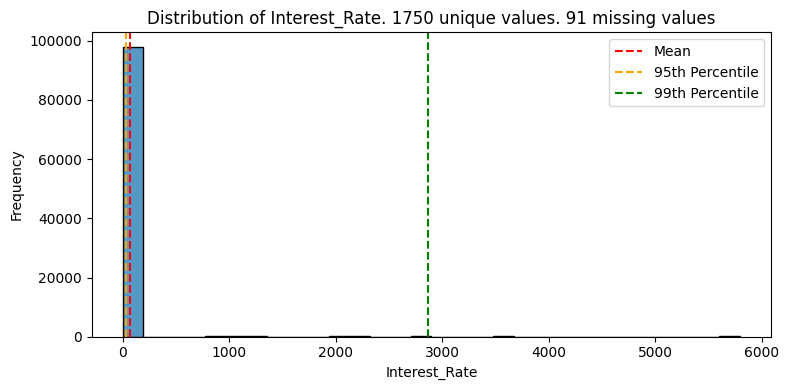

<Figure size 640x480 with 0 Axes>

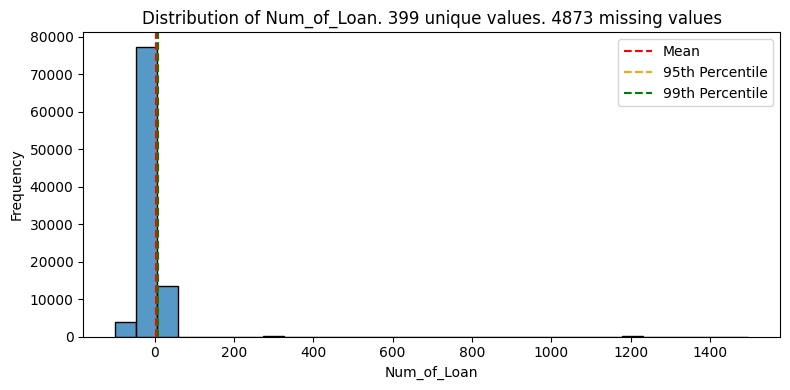

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


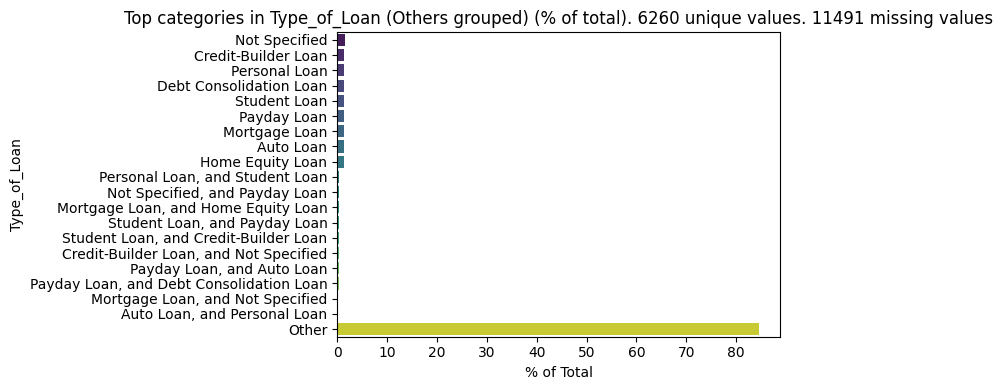

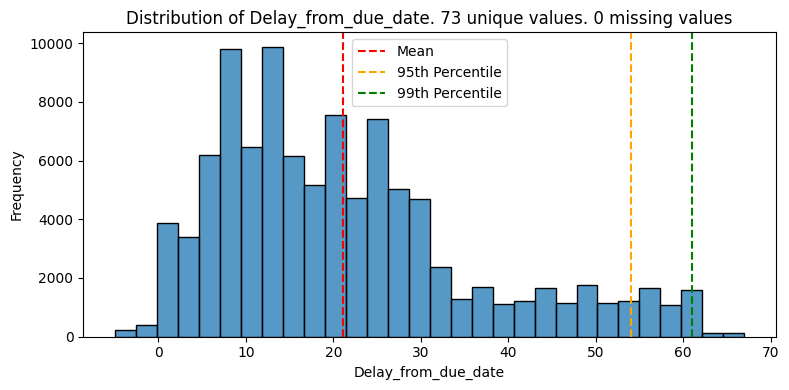

<Figure size 640x480 with 0 Axes>

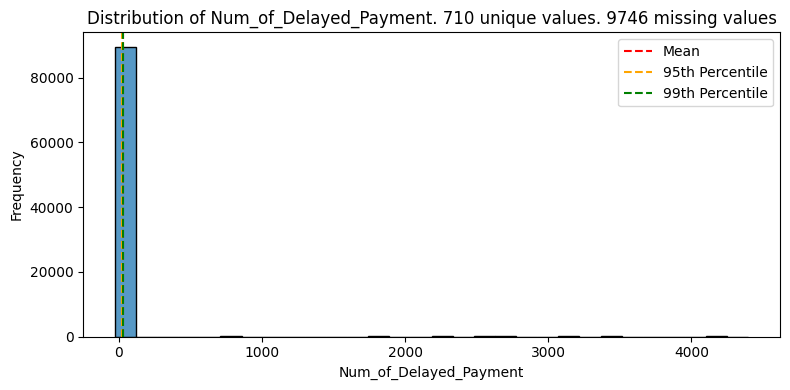

<Figure size 640x480 with 0 Axes>

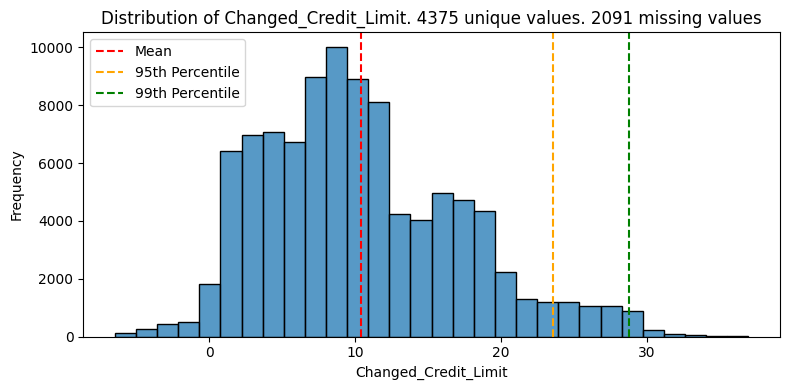

<Figure size 640x480 with 0 Axes>

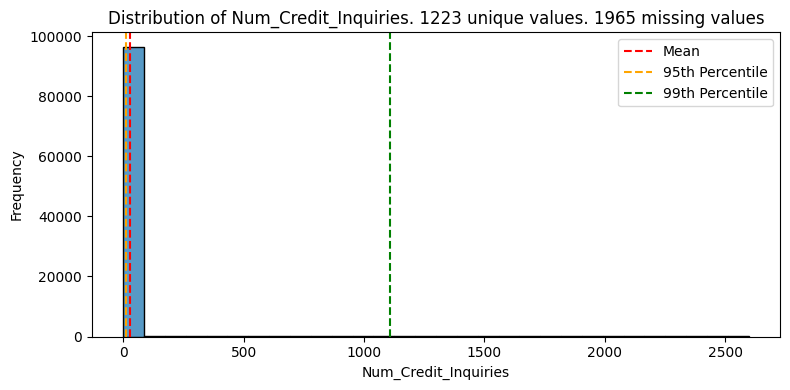

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


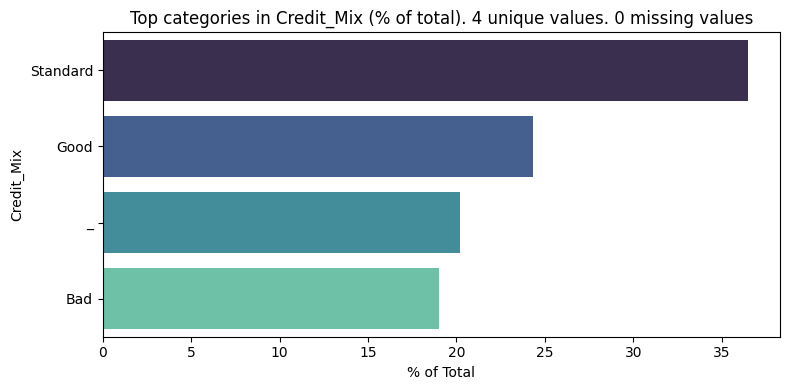

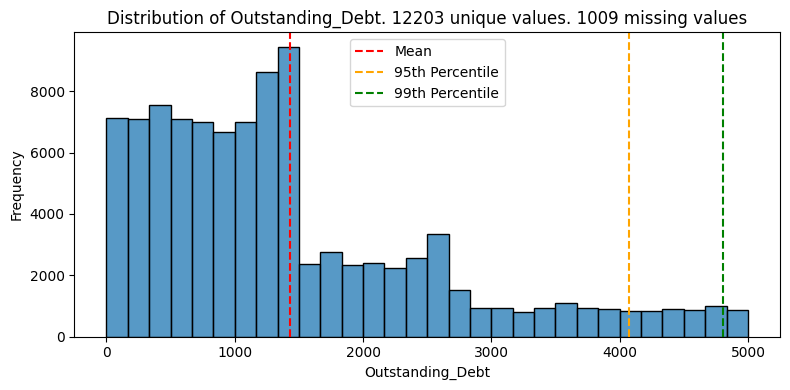

<Figure size 640x480 with 0 Axes>

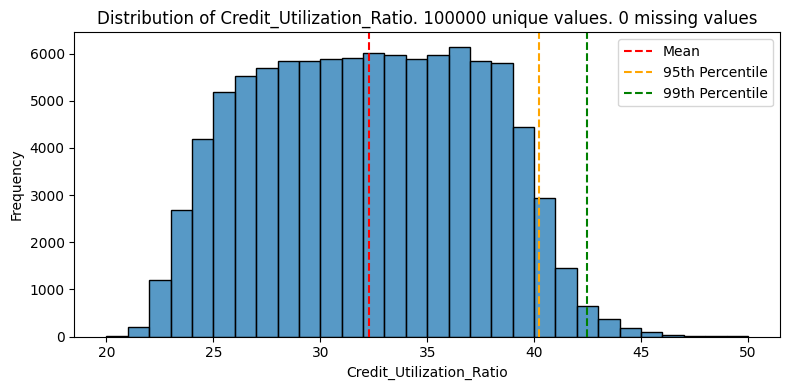

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


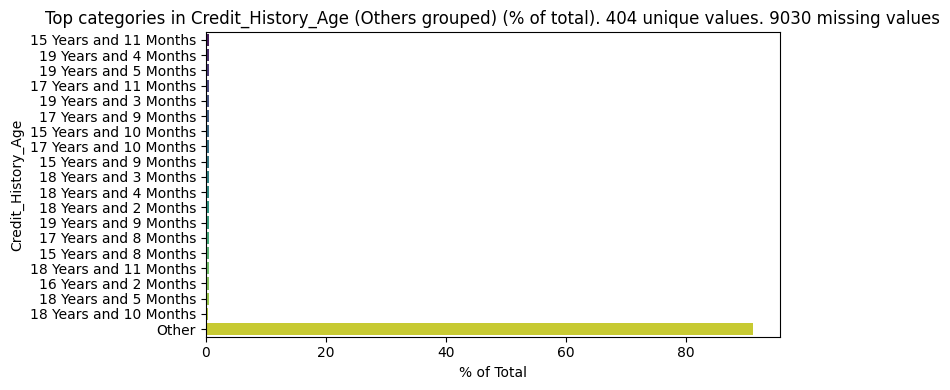

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


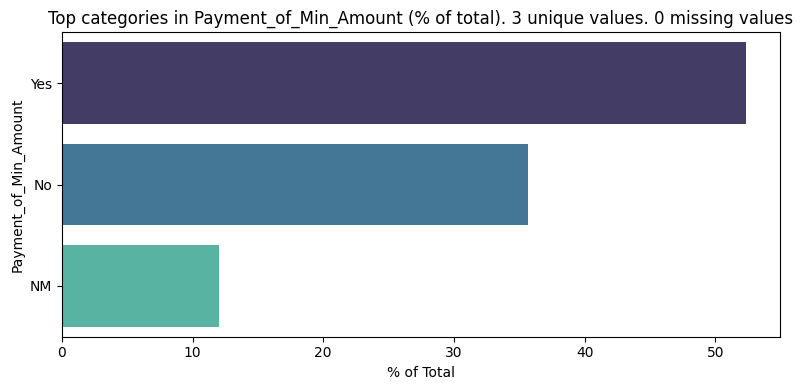

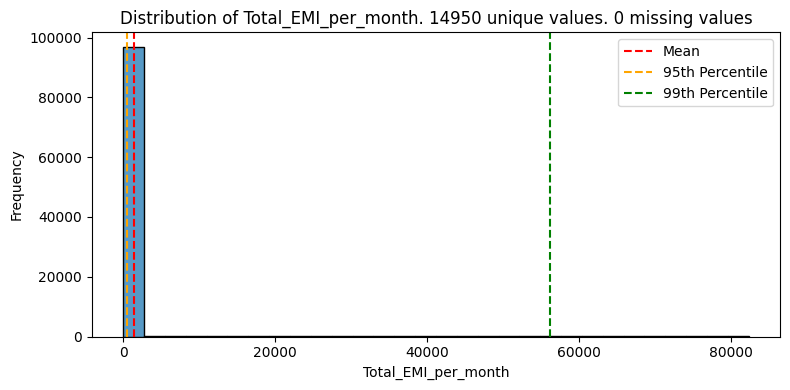

<Figure size 640x480 with 0 Axes>

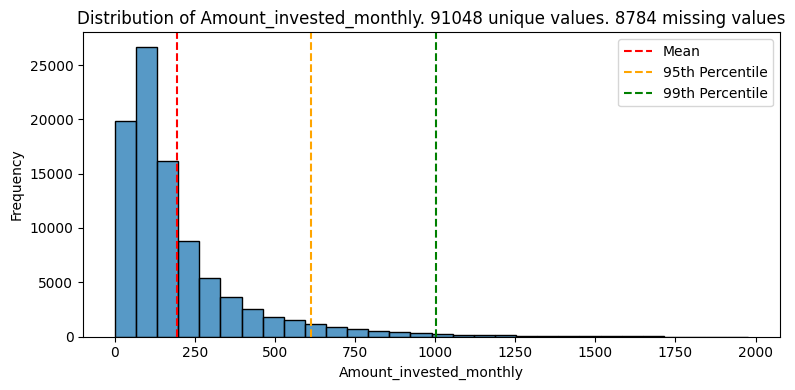

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


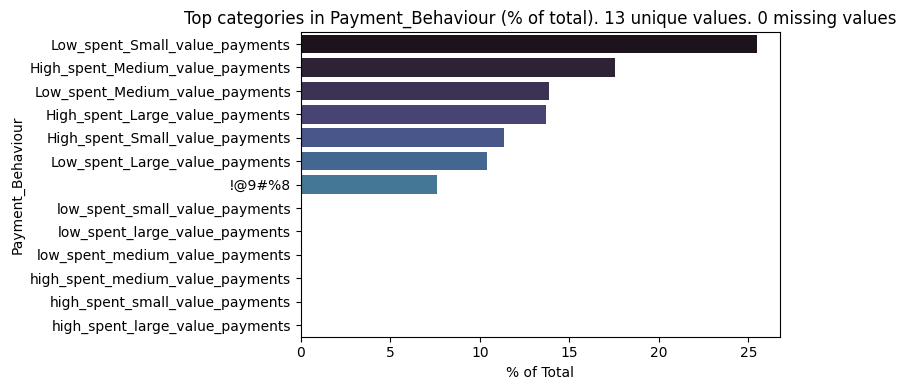

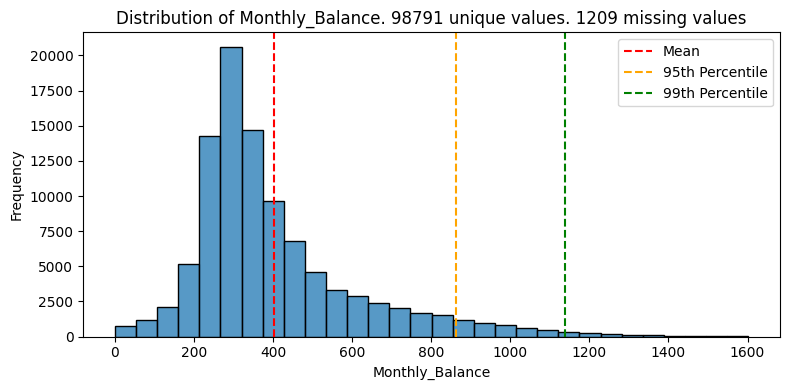

<Figure size 640x480 with 0 Axes>

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


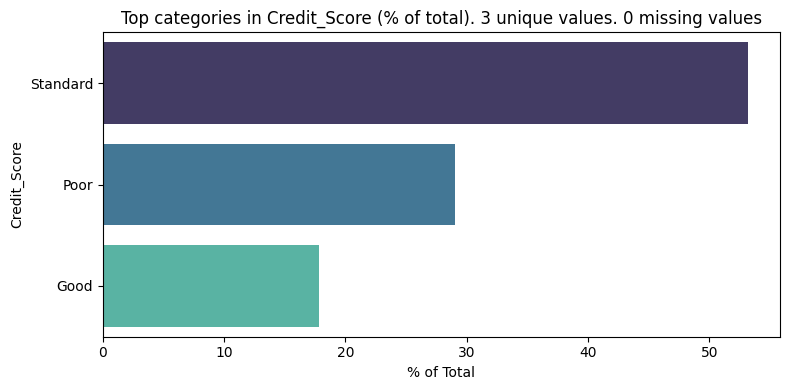

In [216]:
# With the data with correct data types and with some cleaning having started, we can start visualizing the variables
for variable in dataset.columns:
    plt.figure(figsize=(8, 4))

    num_unique = dataset[variable].nunique()
    num_missing = dataset[variable].isnull().sum()

    if variable in numerical_variables: # Numerical variables

        summary_stats = dataset[variable].describe(percentiles=[0.95, 0.99]).transpose()
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        sns.histplot(dataset[variable], bins=30)
        plt.axvline(mean, color='red', linestyle='--', label='Mean')
        plt.axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        plt.axvline(p99, color='green', linestyle='--', label='99th Percentile')

        plt.title(f'Distribution of {variable}. {num_unique} unique values. {num_missing} missing values')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif variable in categorical_variables and dataset[variable].nunique() <= 20:
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)

    elif variable in categorical_variables:
        # Calculate percentage distribution for all categories
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)


    plt.tight_layout()
    plt.show()


# Feature Engineering

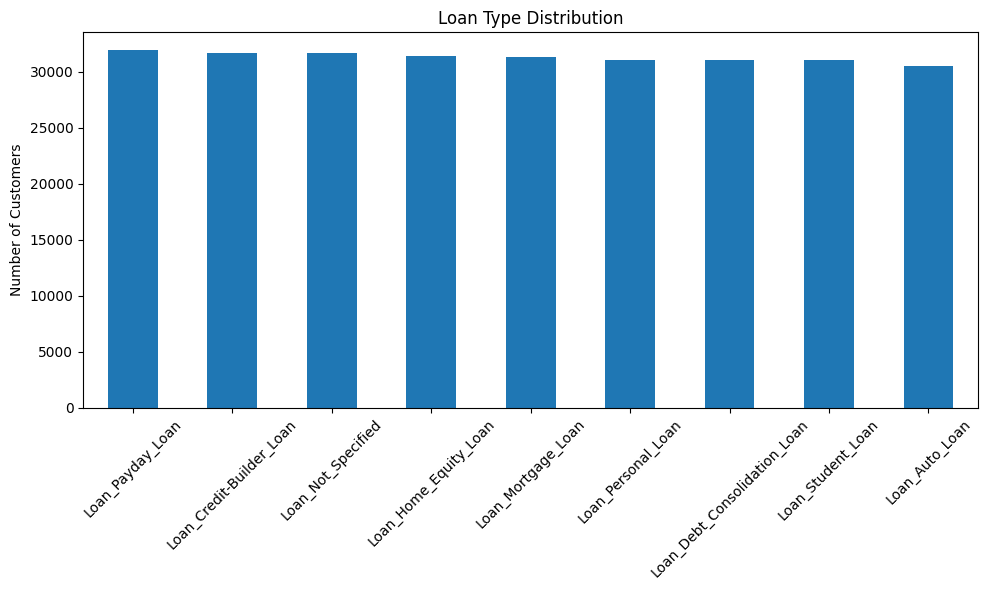

In [217]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Clean and split the loan strings
loans = (
    dataset['Type_of_Loan'].fillna('')
       .str.replace(r'\s+and\s+', ',', regex=True)
       .str.replace(r',+', ',', regex=True)
       .str.strip(' ,')
)
loan_lists = loans.str.split(',').apply(lambda toks: [t.strip() for t in toks if t.strip()])

# 2. Multi-hot encode
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(
    mlb.fit_transform(loan_lists),
    columns=['Loan_' + c.replace(' ', '_').title() for c in mlb.classes_],
    index=dataset.index
)

# 3. Merge and drop original
dataset = pd.concat([dataset, dummies], axis=1).drop(columns=['Type_of_Loan'])

# 4. Plot distribution
counts = dummies.sum().sort_values(ascending=False)
counts.plot.bar(figsize=(10,6), rot=45, title='Loan Type Distribution')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


In [218]:
dummies = mlb.classes_.tolist()
print(dummies)

['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']


In [219]:
# Debt-to-Income
dataset['DTI'] = dataset['Outstanding_Debt'] / dataset['Annual_Income']

# EMI-to-Income
dataset['EMI_Ratio'] = dataset['Total_EMI_per_month'] / dataset['Monthly_Inhand_Salary']

dataset['log_OutDebt']   = np.log1p(dataset['Outstanding_Debt'])
dataset['log_AnnIncome'] = np.log1p(dataset['Annual_Income'])
dataset['log_EMI']       = np.log1p(dataset['Total_EMI_per_month'])

# binning
# Age buckets
bins_age = [0, 25, 35, 50, dataset['Age'].max()]
labels_age = ['0-25','26-35','36-50','51+']
dataset['Age_Group'] = pd.cut(dataset['Age'], bins=bins_age, labels=labels_age)

# Income quartiles
dataset['Income_Quartile'] = pd.qcut(dataset['Annual_Income'], q=4, labels=False) + 1

# Credit history length

# Converting credit_history_age to months

def extract_months(value):
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r'\d+', value)
    if not numbers:
        return np.nan
    years = int(numbers[0]) if len(numbers) > 0 else 0
    months = int(numbers[1]) if len(numbers) > 1 else 0
    return years * 12 + months


dataset['Credit_History_Age'] = dataset['Credit_History_Age'].apply(extract_months)


# 1) Convert Credit_History_Age (in months) from object to numeric
dataset['Credit_History_Age'] = pd.to_numeric(
    dataset['Credit_History_Age'], 
    errors='coerce'
)

# 2) Define bins
bins_hist   = [0, 100, 300, 999]
labels_hist = ['Short', 'Medium', 'Long']

# 3) Apply pd.cut with those bins
dataset['History_Length'] = pd.cut(
    dataset['Credit_History_Age'],
    bins=bins_hist,
    labels=labels_hist,
    right=False     # so that exactly 24→Medium, 60→Long
)

In [220]:
dataset.drop(['ID', 'Customer_ID', 'Name', 'SSN', ], axis=1, inplace=True)
# I'm dropping type of loan just for the sake of not adding complexity now


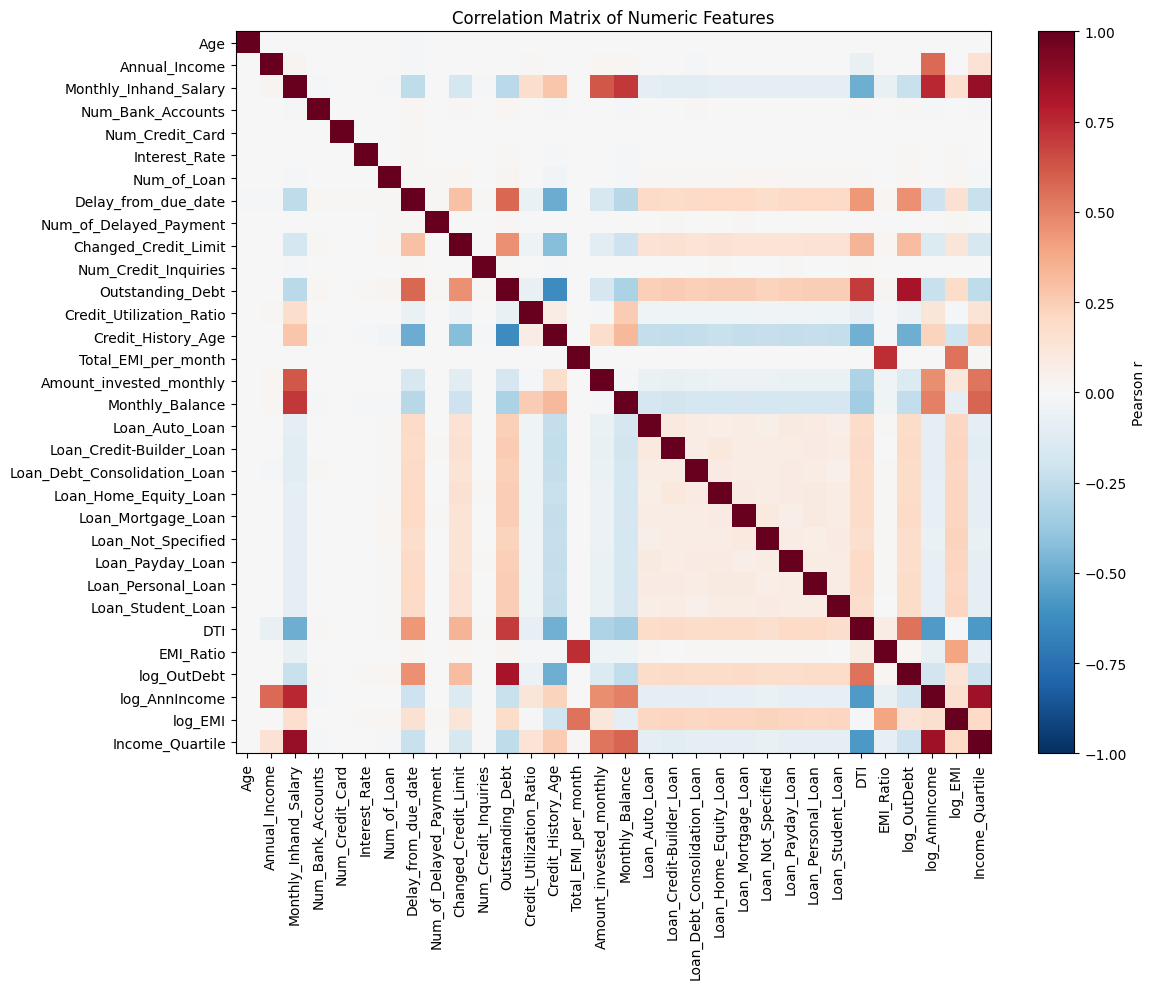

Highly correlated feature pairs (|r| > 0.7):
               feature_1              feature_2      corr
0        Income_Quartile  Monthly_Inhand_Salary  0.871728
1        Income_Quartile          log_AnnIncome  0.845090
2       Outstanding_Debt            log_OutDebt  0.823493
3  Monthly_Inhand_Salary          log_AnnIncome  0.751941
4              EMI_Ratio    Total_EMI_per_month  0.741065
5        Monthly_Balance  Monthly_Inhand_Salary  0.704899


In [221]:
# 1. Grab just the numeric features (so categorical cuts like Age_Group/History_Length are excluded)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

# 2. Compute the Pearson correlation matrix
corr = dataset[numeric_cols].corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(np.arange(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(np.arange(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# 4. Extract all unique feature‐pairs with |r| > 0.7
corr_pairs = (
    corr
      .abs()                          # absolute correlations
      .unstack()                      # long form
      .reset_index(name='corr')       # name the new column
)
corr_pairs.columns = ['feature_1', 'feature_2', 'corr']

# filter out self‐pairs and duplicates (A,B vs B,A)
strong_pairs = (
    corr_pairs[
        (corr_pairs['feature_1'] < corr_pairs['feature_2']) &
        (corr_pairs['corr'] > 0.7)
    ]
    .sort_values('corr', ascending=False)
    .reset_index(drop=True)
)

print("Highly correlated feature pairs (|r| > 0.7):")
print(strong_pairs)

# Modelling

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

data = dataset.copy()
# Separate features and target
target_col = 'Credit_Score' 
X = data.drop(columns=[target_col]).copy()

# Explicit category order
encoder = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])

# Must be 2D input
y = data[[target_col]].copy()
y[target_col] = encoder.fit_transform(y[[target_col]]).astype(int)

# 2) Split off test set (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# 3) Split train vs. validation (of the remaining 85%, we want ~70/15 overall)
val_fraction = 0.15 / 0.85   # ≈0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_fraction,
    stratify=y_train_val,
    random_state=42
)

# 4) Quick check of class distributions
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Val   distribution:\n", y_val.value_counts(normalize=True))
print("Test  distribution:\n", y_test.value_counts(normalize=True))


Train distribution:
 Credit_Score
1               0.531736
0               0.289976
2               0.178288
Name: proportion, dtype: float64
Val   distribution:
 Credit_Score
1               0.531765
0               0.289981
2               0.178255
Name: proportion, dtype: float64
Test  distribution:
 Credit_Score
1               0.531733
0               0.290000
2               0.178267
Name: proportion, dtype: float64


In [223]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Month                         100000 non-null  object  
 1   Age                           94974 non-null   float64 
 2   Occupation                    99909 non-null   object  
 3   Annual_Income                 92932 non-null   float64 
 4   Monthly_Inhand_Salary         84920 non-null   float64 
 5   Num_Bank_Accounts             99909 non-null   float64 
 6   Num_Credit_Card               99909 non-null   float64 
 7   Interest_Rate                 99909 non-null   float64 
 8   Num_of_Loan                   95127 non-null   float64 
 9   Delay_from_due_date           100000 non-null  int64   
 10  Num_of_Delayed_Payment        90254 non-null   float64 
 11  Changed_Credit_Limit          97909 non-null   float64 
 12  Num_Credit_Inquiries          9

In [224]:
X.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Loan_Auto_Loan,Loan_Credit-Builder_Loan,Loan_Debt_Consolidation_Loan,Loan_Home_Equity_Loan,Loan_Mortgage_Loan,Loan_Not_Specified,Loan_Payday_Loan,Loan_Personal_Loan,Loan_Student_Loan,DTI,EMI_Ratio,log_OutDebt,log_AnnIncome,log_EMI,Income_Quartile
count,94974.000000,9.293200e+04,84920.000000,99909.000000,99909.000000,99909.000000,95127.000000,100000.000000,90254.000000,97909.000000,98035.000000,98991.000000,100000.000000,90970.000000,100000.000000,91216.000000,98791.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,9.199300e+04,84920.000000,98991.000000,92932.000000,100000.000000,92932.000000
mean,110.863615,1.784985e+05,4194.071131,17.104395,22.495621,72.469027,2.781765,21.068780,31.027777,10.389025,27.754251,1426.503700,32.285173,221.195405,1403.118217,195.539456,402.551258,0.305300,0.316980,0.310120,0.313690,0.313340,0.316520,0.31915,0.310720,0.310120,6.006215e-02,0.604822,6.848876,10.592144,4.102308,2.499903
std,689.228869,1.443061e+06,3183.605038,117.454091,129.115463,466.383442,62.528021,14.860104,226.956479,6.789496,193.177339,1155.045753,5.116875,99.741364,8306.041270,199.564527,213.925499,0.460537,0.465302,0.462545,0.463994,0.463854,0.465121,0.46615,0.462791,0.462545,8.724512e-02,4.979210,1.083137,0.967540,1.963146,1.118098
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,-100.000000,-5.000000,-27.000000,-6.490000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.086800e-07,0.000000,0.207014,8.854655,0.000000,1.000000
25%,24.000000,1.943628e+04,1625.597917,3.000000,4.000000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.080000,28.052567,144.000000,30.306660,72.236692,270.106630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,9.252035e-03,0.012618,6.340500,9.874948,3.443831,1.000000
50%,33.000000,3.755074e+04,3093.745000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.370000,32.305784,219.000000,69.249473,128.954538,336.731225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.776677e-02,0.025243,7.062509,10.533475,4.252053,2.000000
75%,42.000000,7.284338e+04,5957.448333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1948.200000,36.496663,302.000000,161.224249,236.815814,470.262938,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.908371e-02,0.042684,7.575174,11.196081,5.088980,3.250000
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,404.000000,82331.000000,1977.326102,1602.040519,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,6.832516e-01,227.739318,8.517007,17.001783,11.318515,4.000000


In [225]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_features = ["Credit_Mix", "Age_Group", "History_Length"]
nominal_features = [col for col in categorical_features if col not in ordinal_features and col not in dummies]
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

credit_mix_order    = ["bad", "standard", "good"]
age_group_order     = ["0-25", "26-35", "36-45",  "51+"]
history_length_order = ["Short", "Medium", "Long"]

ordinal_categories = [
    credit_mix_order,
    age_group_order,
    history_length_order,
]

In [226]:
def correct_month(month_str):
    # Define the canonical month names.
    canonical_months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    # Clean the input string.
    candidate = month_str.strip().lower()
    
    # Find the closest match (using a cutoff for similarity).
    matches = difflib.get_close_matches(candidate, [m.lower() for m in canonical_months], n=1, cutoff=0.6)
    
    if matches:
        # Return the canonical name matching the found close match.
        for m in canonical_months:
            if m.lower() == matches[0]:
                return m
    else:
        # Fallback: return the original string capitalized.
        return month_str.capitalize()

In [227]:
def business_logic_limits(df, column, lower_limit, upper_limit):
    """
    Replace values below lower_limit with NaN and values above upper_limit with NaN.
    
    Parameters:
    - df: DataFrame containing the data
    - column: The column name where outliers should be replaced with NaN
    - lower_limit: The minimum allowed value for the column
    - upper_limit: The maximum allowed value for the column
    
    Returns:
    - DataFrame with outliers replaced by NaN
    """
    # Replace values below the lower limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x < lower_limit else x)
    
    # Replace values above the upper limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x > upper_limit else x)
    
    return df


In [228]:
def winsorize_by_iqr(df, column, lower_threshold_factor=3, upper_threshold_factor=3):
    """
    Apply winsorization to a column in the DataFrame based on the IQR (Interquartile Range) method.
    Values below the lower threshold are replaced by the lower threshold and values above the upper
    threshold are replaced by the upper threshold.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: The column name to apply winsorization on.
    - lower_threshold_factor: The factor to calculate the lower threshold. Default is 1.5 (commonly used).
    - upper_threshold_factor: The factor to calculate the upper threshold. Default is 1.5 (commonly used).
    
    Returns:
    - df: DataFrame with winsorized values.
    """
    
    # Calculate the IQR (Interquartile Range)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    p95 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds based on the IQR method
    lower_bound = Q1 - lower_threshold_factor * IQR
    upper_bound = min(p95, Q3 + upper_threshold_factor * IQR)
    
    # Apply winsorization: cap values that are below the lower bound or above the upper bound
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    
    return df

In [229]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self, cleaning_rules, lower_threshold_factor=3, upper_threshold_factor=3):
        self.cleaning_rules = cleaning_rules
        self.lower_threshold_factor = lower_threshold_factor
        self.upper_threshold_factor = upper_threshold_factor
        self._winsor_bounds = {}
        self.allow_underscore = ['Payment_Behaviour']

    def fit(self, X, y=None):
        self._winsor_bounds = {}
        for variable in X.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                if rule.get('nonsense_outliers', False):
                    col = X[variable]
                    Q1 = col.quantile(0.25)
                    Q3 = col.quantile(0.75)
                    p95 = col.quantile(0.95)
                    IQR = Q3 - Q1
                    lower = Q1 - self.lower_threshold_factor * IQR
                    upper = min(p95, Q3 + self.upper_threshold_factor * IQR)
                    self._winsor_bounds[variable] = (lower, upper)
        return self

    def transform(self, X):
        cleaned_data = X.copy()
        # Apply underscore removal to all object columns except those in allow_underscore
        for col in cleaned_data.columns:
            if cleaned_data[col].dtype == 'object':
                cleaned_data[col] = cleaned_data[col].astype(str).str.lower()
            if cleaned_data[col].dtype == 'object' and col not in self.allow_underscore:
                cleaned_data[col] = cleaned_data[col].astype(str).str.replace("_", "", regex=False)
            if col == "Month":
                cleaned_data["Month"] = cleaned_data["Month"].apply(correct_month)
            if col == "Occupation":
                cleaned_data["Occupation"] = cleaned_data["Occupation"].replace("", np.nan)
        
        # Then apply other cleaning rules
        for variable in cleaned_data.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                # Apply business logic limits if needed
                if rule.get("is_numeric", False) and rule.get("business_logic", False):
                    min_val = rule.get("business_logic_min", None)
                    max_val = rule.get("business_logic_max", None)
                    business_logic_limits(cleaned_data, variable, min_val, max_val)
                # Apply winsorization using stored bounds
                if rule.get("nonsense_outliers", False):
                    bounds = self._winsor_bounds.get(variable, None)
                    if bounds is not None:
                        lower, upper = bounds
                        cleaned_data[variable] = cleaned_data[variable].apply(
                            lambda x: lower if x < lower else (upper if x > upper else x)
                        )
        return cleaned_data

In [230]:
cleaning_rules = {
    "ID": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": True,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Customer_ID": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Month": {
        "is_numeric": False,
        "business_logic": True,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Name": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Age": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": True,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "SSN": {
        "is_numeric": False,
        "business_logic": True,
        "all_values_unique": True,
        "single_value_per_customer": True,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Occupation": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": False,
    },
    "Annual_Income": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 10000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "logical_value_substitution": True,
        "sequence_by_step": False,
        "nonsense_outliers": True,
    },
    "Monthly_Inhand_Salary": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Bank_Accounts": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Credit_Card": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Interest_Rate": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Loan": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Type_of_Loan": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Delay_from_due_date": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 365,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Delayed_Payment": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Changed_Credit_Limit": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Num_Credit_Inquiries": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Credit_Mix": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Outstanding_Debt": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_Utilization_Ratio": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0.0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_History_Age": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_value_filling": None,
        "single_change": False,
        "sequence_by_step": True,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Payment_of_Min_Amount": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Total_EMI_per_month": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 200000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Amount_invested_monthly": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Payment_Behaviour": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Monthly_Balance": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Credit_Score": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    }
}


In [231]:
X_train_copy = X_train.copy()
X_train_copy.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Loan_Auto_Loan,Loan_Credit-Builder_Loan,Loan_Debt_Consolidation_Loan,Loan_Home_Equity_Loan,Loan_Mortgage_Loan,Loan_Not_Specified,Loan_Payday_Loan,Loan_Personal_Loan,Loan_Student_Loan,DTI,EMI_Ratio,log_OutDebt,log_AnnIncome,log_EMI,Age_Group,Income_Quartile,History_Length
18085,June,33.0,Developer,115484.200,9403.683333,5.0,6.0,5.0,0.0,2,9.0,4.64,0.0,Good,715.73,24.818878,228.0,No,0.000000,1244.766428,Low_spent_Small_value_payments,NaN,0,0,0,0,0,0,0,0,0,0.006198,0.000000,6.574699,11.656898,0.000000,26-35,4.0,Medium
51487,August,38.0,Manager,NaN,2224.390000,8.0,3.0,6.0,4.0,18,14.0,0.84,1.0,Standard,1213.10,22.348618,251.0,No,52.449531,196.088419,Low_spent_Large_value_payments,243.901050,1,1,1,1,0,0,0,0,0,NaN,0.023579,7.101758,NaN,3.978738,36-50,NaN,Medium
95532,May,55.0,Doctor,10233.555,1046.796250,7.0,4.0,3.0,1.0,14,17.0,11.20,4.0,Good,757.92,31.853846,319.0,No,7.648424,100.334310,Low_spent_Small_value_payments,286.696891,0,0,0,1,0,0,0,0,0,0.074062,0.007307,6.631896,9.233525,2.157377,51+,1.0,Long
39285,June,39.0,Engineer,60437.280,4948.440000,6.0,4.0,8.0,4.0,21,8.0,19.55,8.0,Standard,2133.53,25.534640,200.0,NM,129.387463,289.158989,!@9#%8,356.297548,0,1,1,1,0,0,0,0,0,0.035302,0.026147,7.666002,11.009378,4.870511,36-50,3.0,Medium
94189,June,44.0,Architect,70447.260,5843.605000,8.0,4.0,1.0,3.0,26,10.0,0.54,6.0,Standard,904.34,40.045036,378.0,NM,111.172179,114.037766,High_spent_Medium_value_payments,609.150555,0,0,0,1,1,0,1,0,0,0.012837,0.019025,6.808311,11.162634,4.720035,36-50,3.0,Long


C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


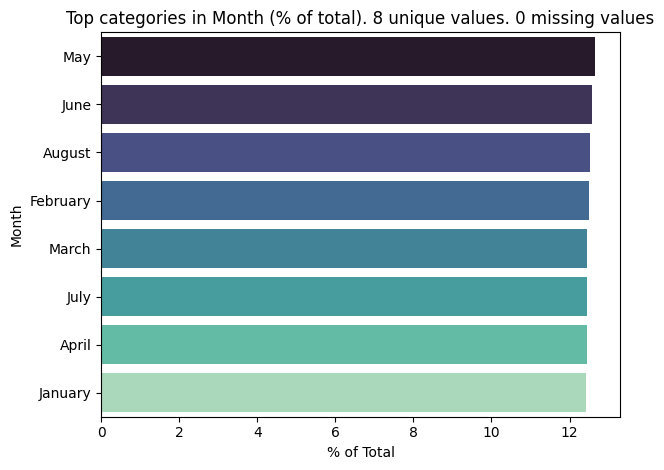

count    64588.000000
mean        33.254815
std         10.662797
min         14.000000
50%         33.000000
95%         52.000000
99%         53.000000
max         53.000000
Name: Age, dtype: float64


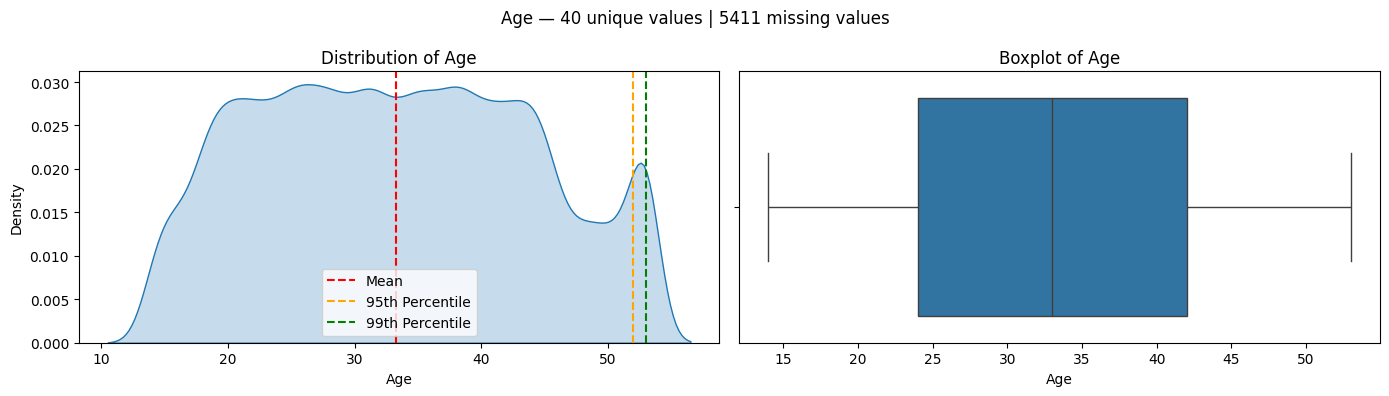

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


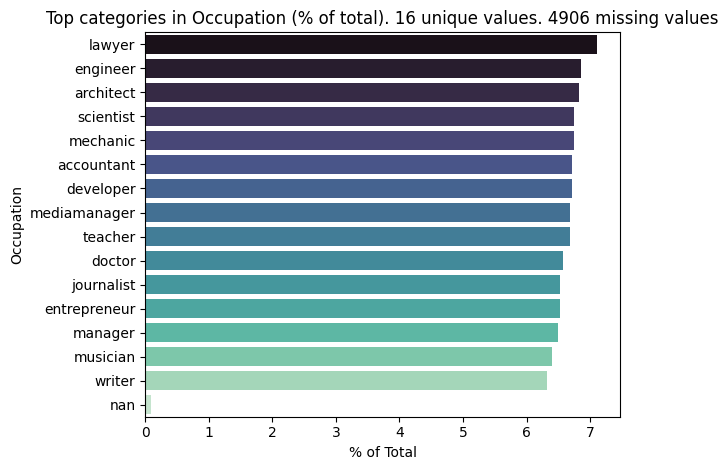

count     64616.000000
mean      49950.441296
std       36503.876610
min        7005.930000
50%       37045.780000
95%      131737.720000
99%      134439.400000
max      134439.400000
Name: Annual_Income, dtype: float64


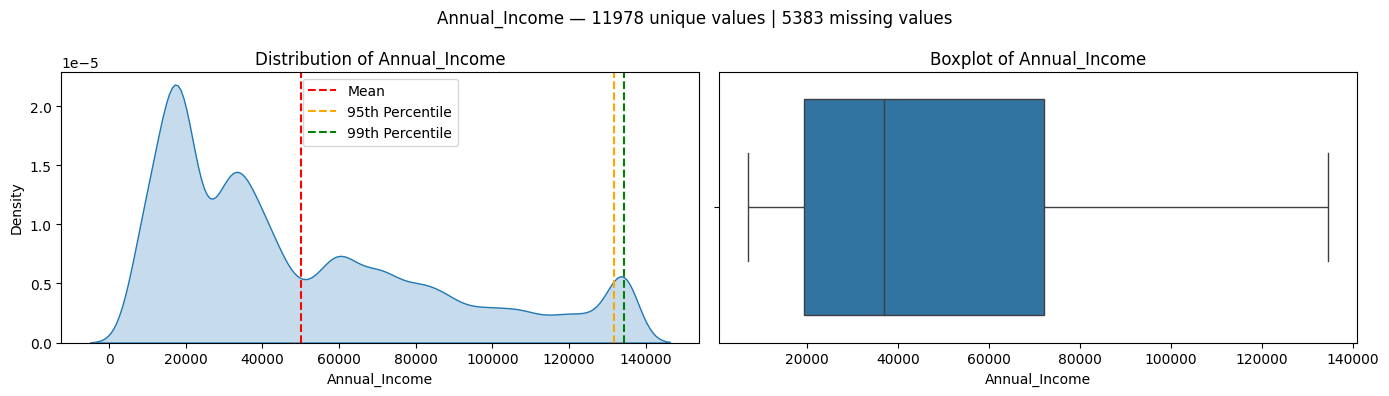

count    59438.000000
mean      4107.269236
std       2973.988807
min        303.645417
50%       3087.595000
95%      10827.830000
99%      10827.830000
max      10827.830000
Name: Monthly_Inhand_Salary, dtype: float64


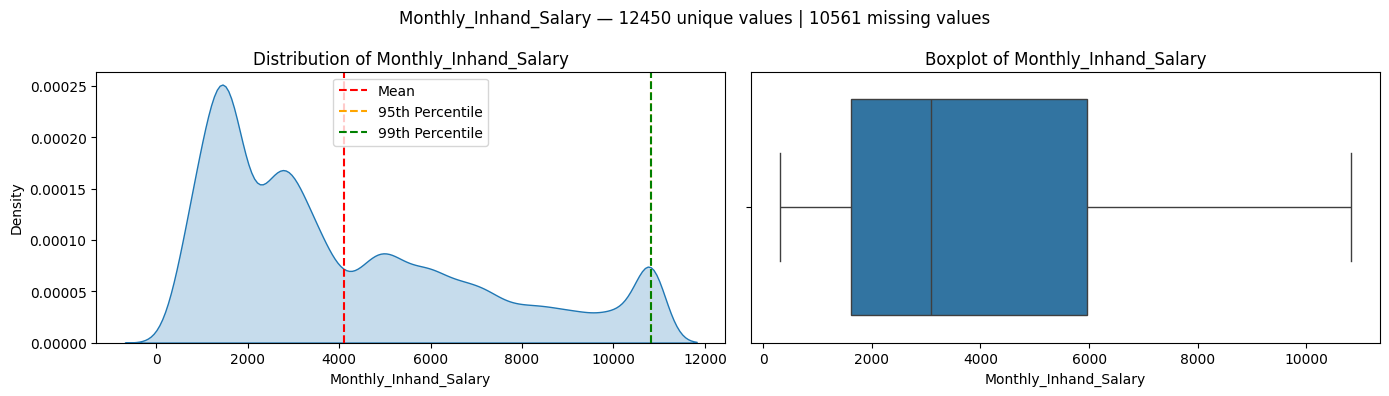

count    68972.000000
mean         5.370585
std          2.589069
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Bank_Accounts, dtype: float64


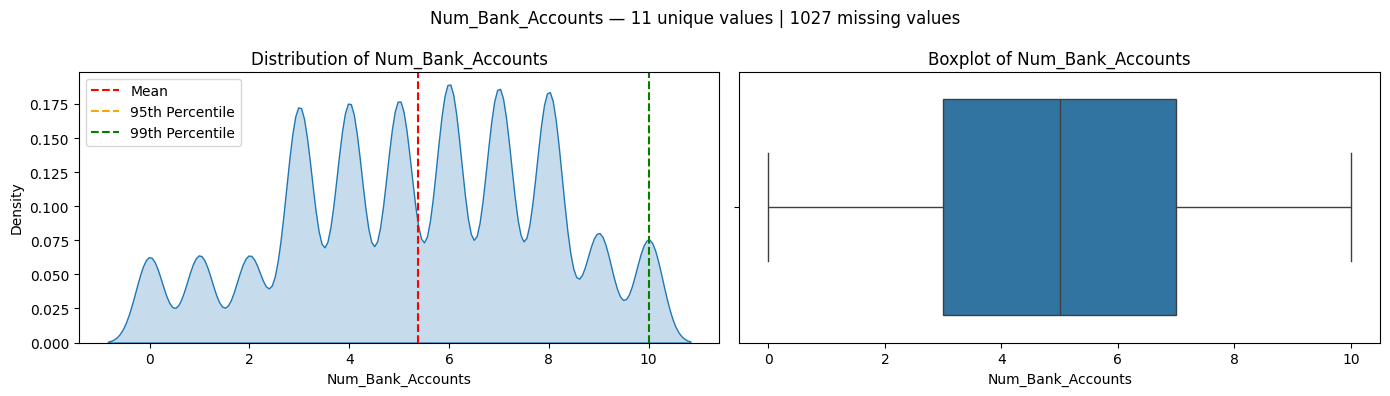

count    68366.000000
mean         5.537285
std          2.069411
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Credit_Card, dtype: float64


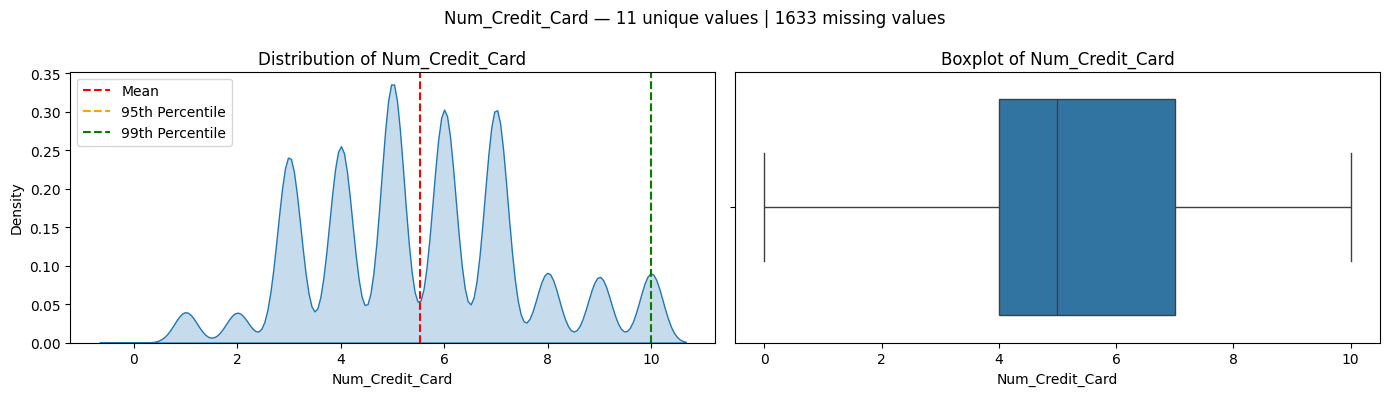

count    68516.000000
mean        14.541611
std          8.723773
min          1.000000
50%         13.000000
95%         31.000000
99%         33.000000
max         33.000000
Name: Interest_Rate, dtype: float64


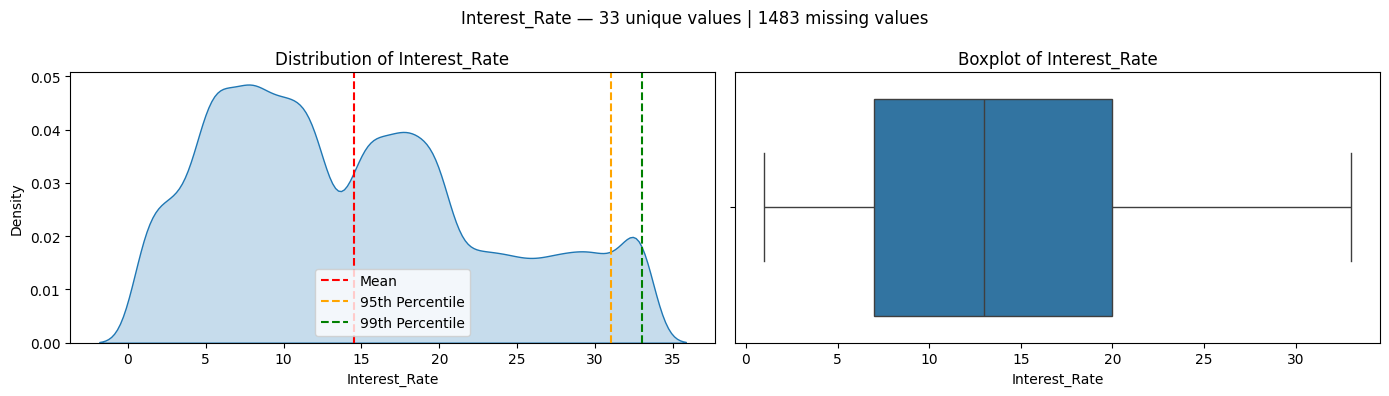

count    63558.000000
mean         3.505570
std          2.368732
min          0.000000
50%          3.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: Num_of_Loan, dtype: float64


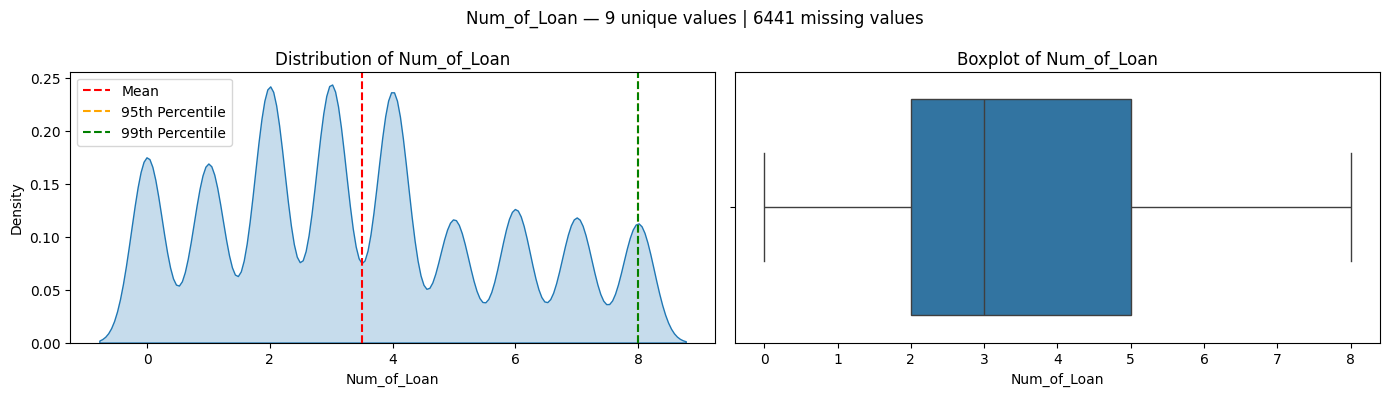

count    69584.000000
mean        21.005404
std         14.256863
min          0.000000
50%         18.000000
95%         54.000000
99%         54.000000
max         54.000000
Name: Delay_from_due_date, dtype: float64


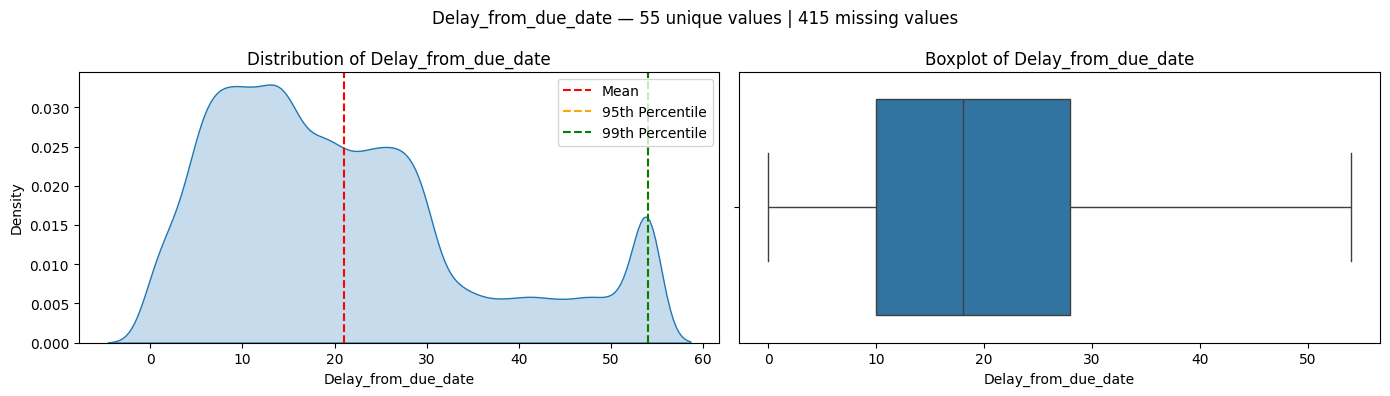

count    62281.000000
mean        13.408070
std          6.135559
min          0.000000
50%         14.000000
95%         23.000000
99%         24.000000
max         24.000000
Name: Num_of_Delayed_Payment, dtype: float64


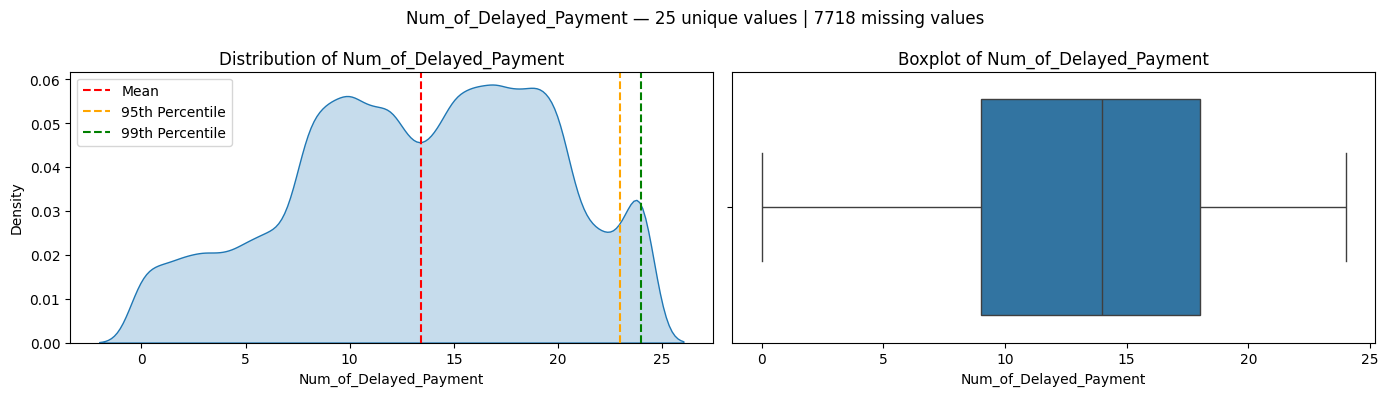

count    68527.000000
mean        10.409300
std          6.799278
min         -6.490000
50%          9.420000
95%         23.647000
99%         28.820000
max         36.970000
Name: Changed_Credit_Limit, dtype: float64


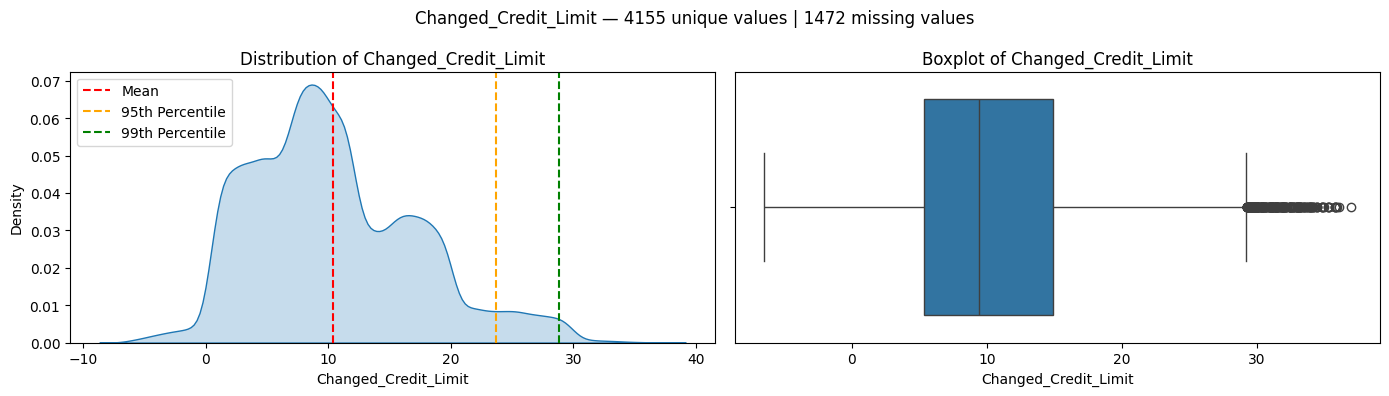

count    67490.000000
mean         5.748941
std          3.750150
min          0.000000
50%          5.000000
95%         12.000000
99%         13.000000
max         13.000000
Name: Num_Credit_Inquiries, dtype: float64


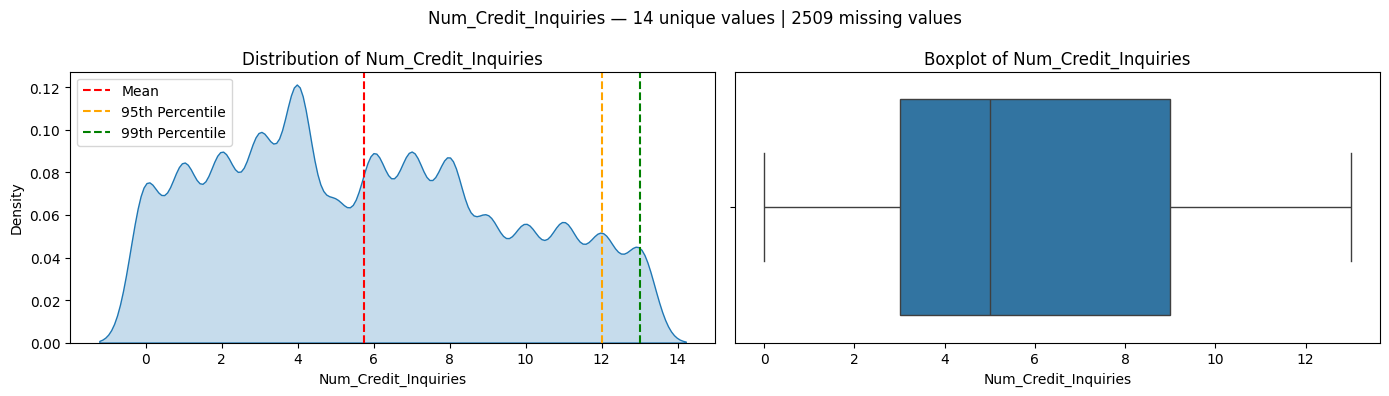

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


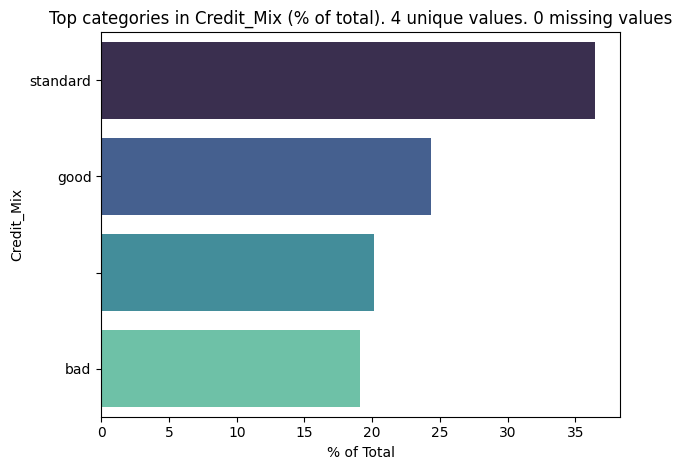

count    69288.000000
mean      1430.595646
std       1155.753807
min          0.230000
50%       1169.200000
95%       4074.720000
99%       4804.760000
max       4998.070000
Name: Outstanding_Debt, dtype: float64


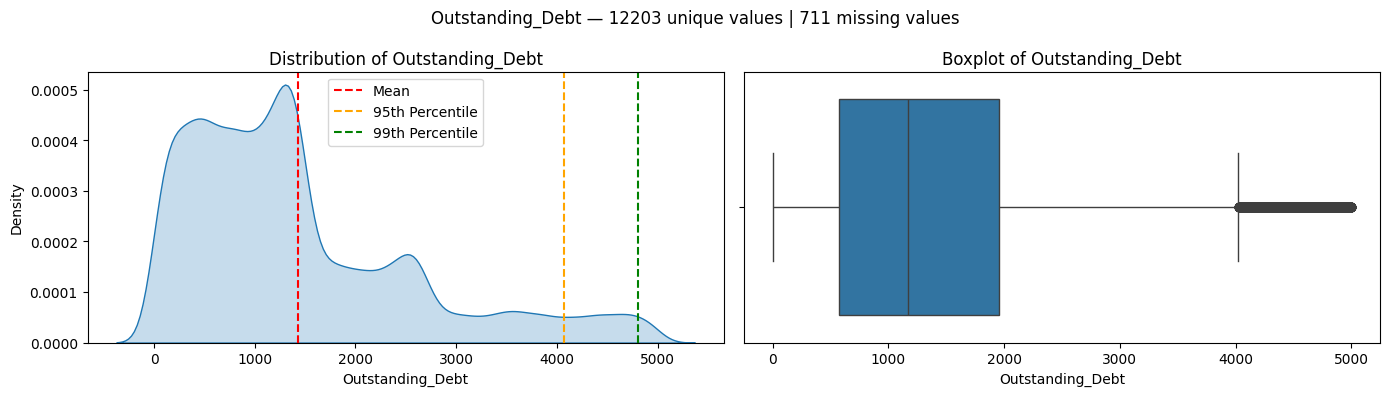

count    69999.000000
mean        32.293081
std          5.125366
min         20.000000
50%         32.340401
95%         40.225969
99%         42.436762
max         50.000000
Name: Credit_Utilization_Ratio, dtype: float64


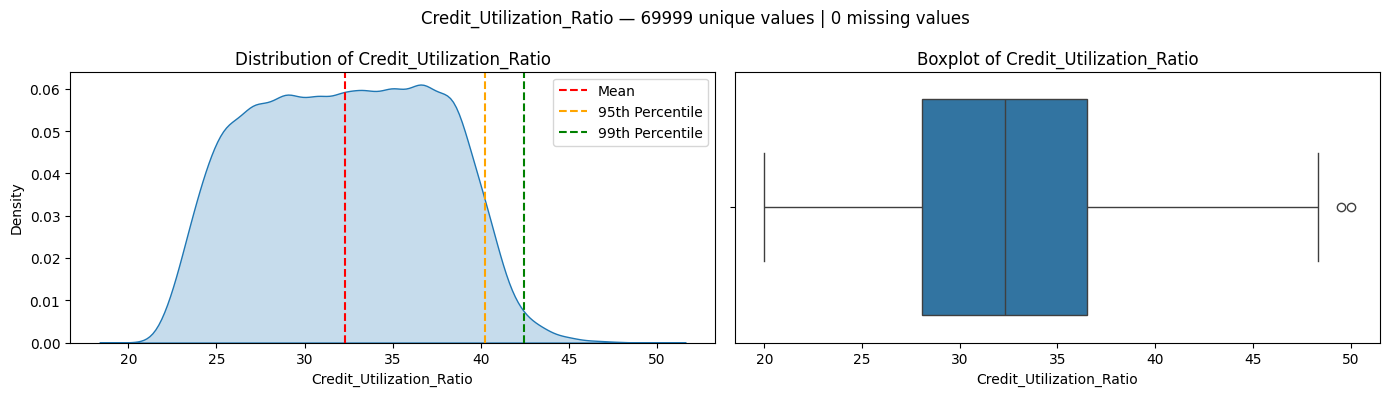

count    63674.000000
mean       220.599538
std         99.716385
min          1.000000
50%        219.000000
95%        381.000000
99%        396.000000
max        404.000000
Name: Credit_History_Age, dtype: float64


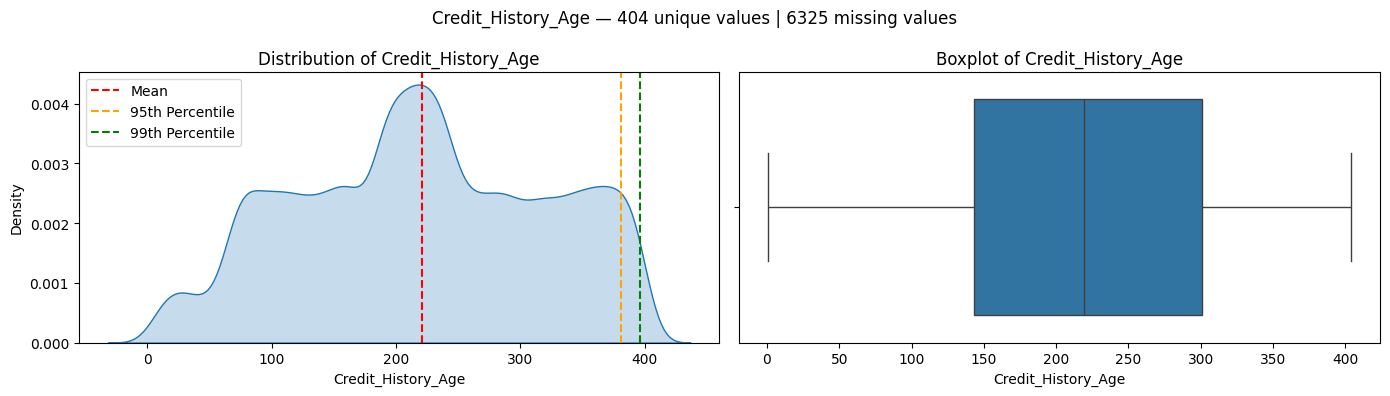

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


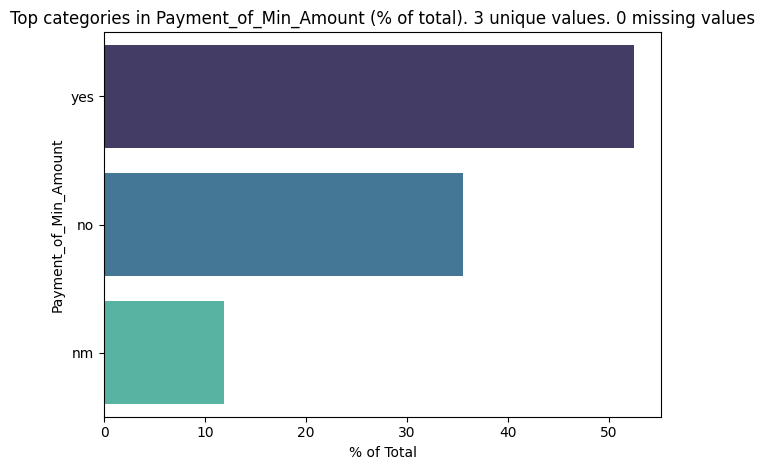

count    69999.000000
mean       112.289987
std        115.439162
min          0.000000
50%         69.266164
95%        432.525753
99%        432.525753
max        432.525753
Name: Total_EMI_per_month, dtype: float64


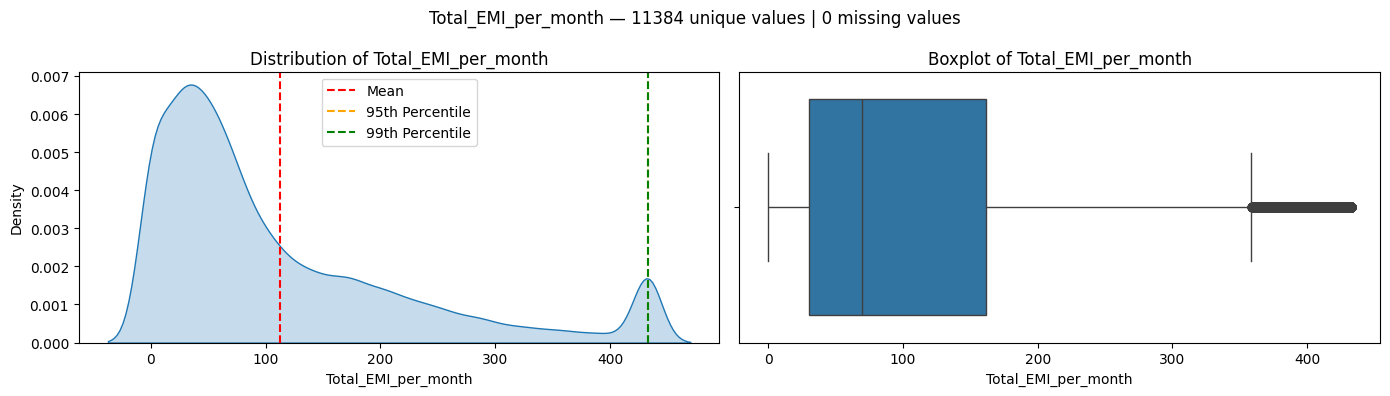

count    63869.000000
mean       184.108898
std        158.238582
min          0.000000
50%        128.827461
95%        615.752022
99%        615.752252
max        615.752252
Name: Amount_invested_monthly, dtype: float64


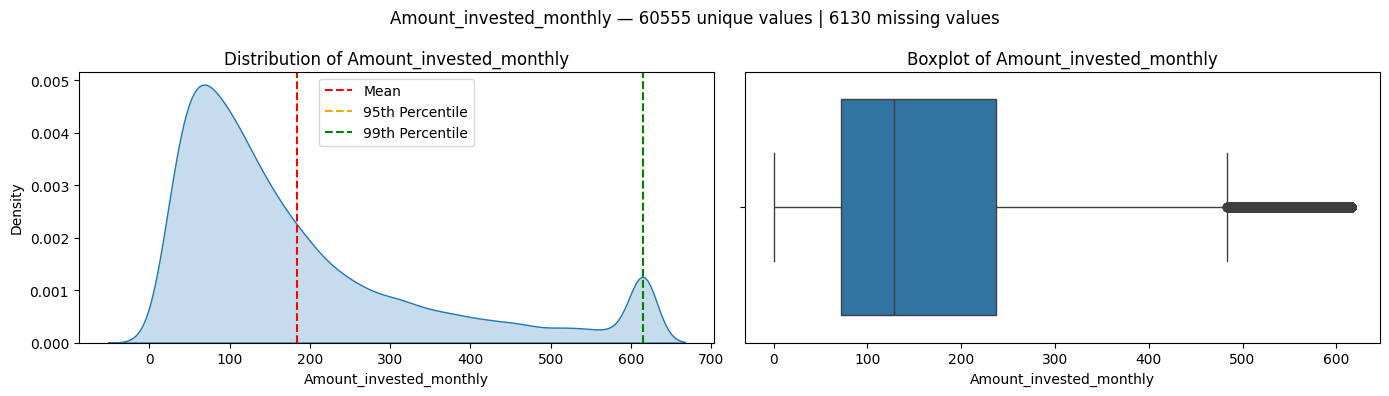

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


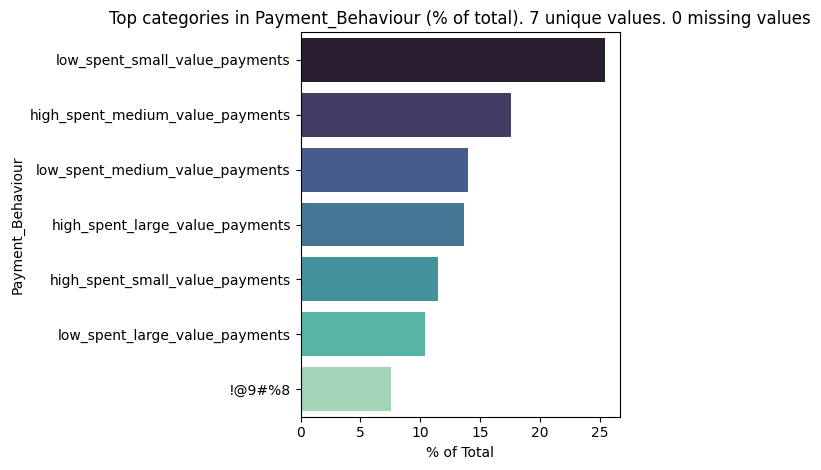

count    69146.000000
mean       393.293438
std        187.675895
min          0.088628
50%        336.348491
95%        858.341245
99%        858.361267
max        858.361267
Name: Monthly_Balance, dtype: float64


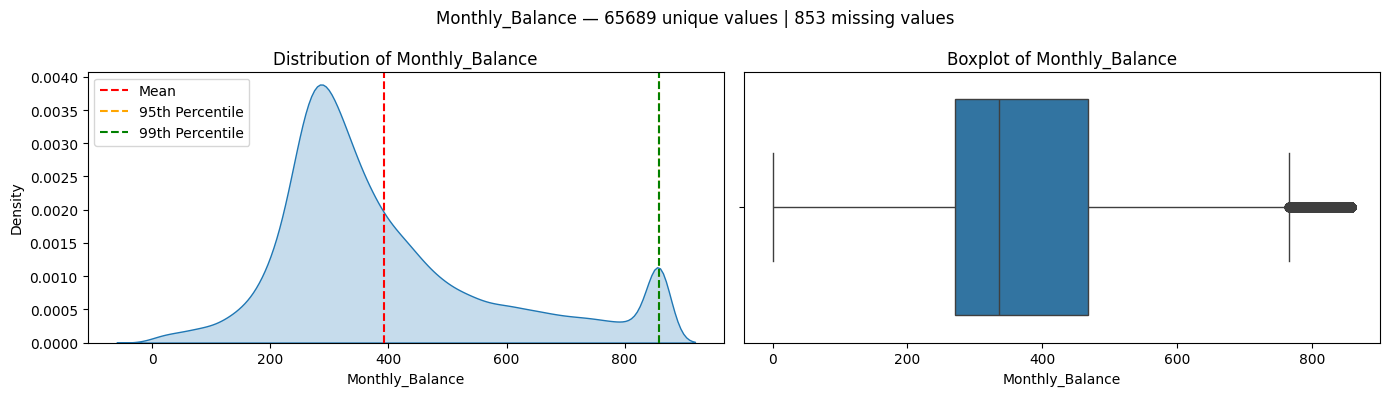

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


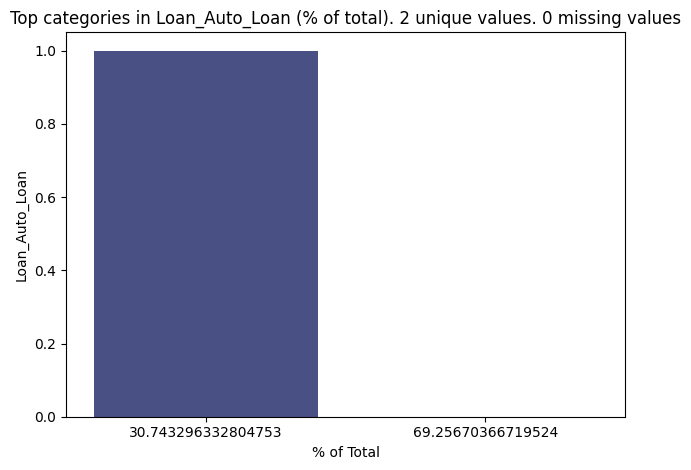

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


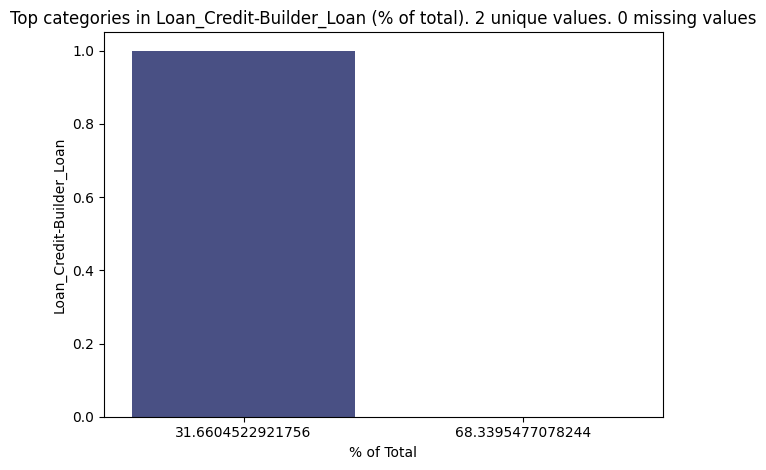

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


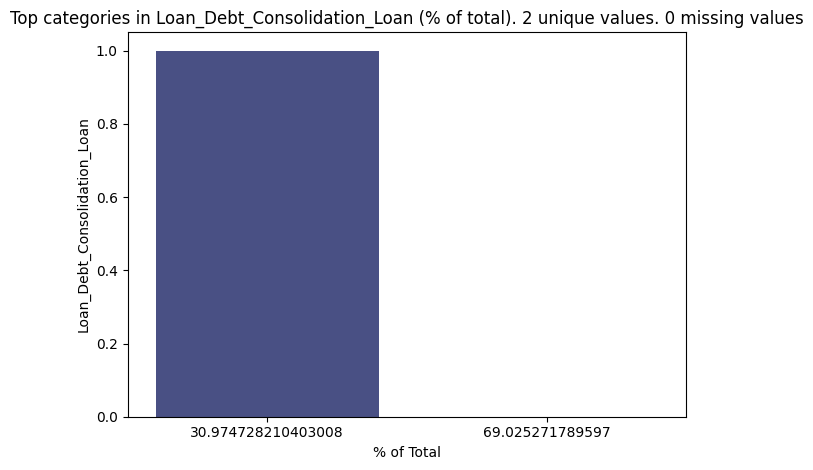

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


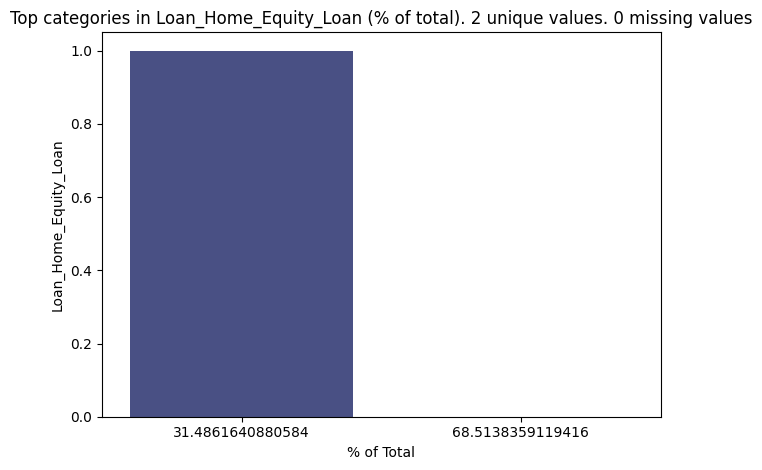

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


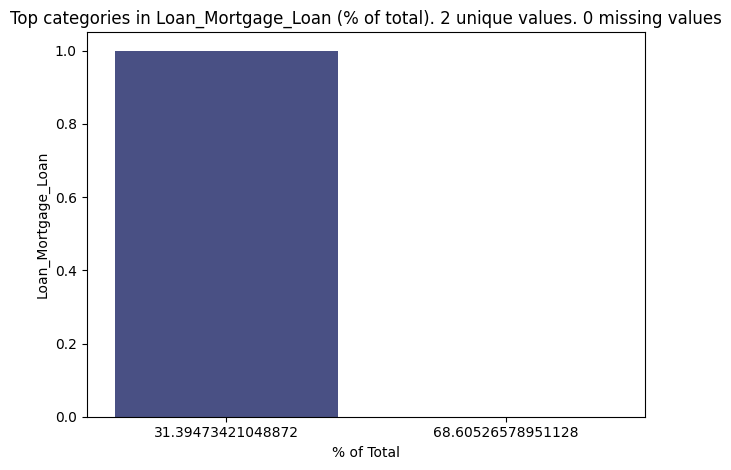

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


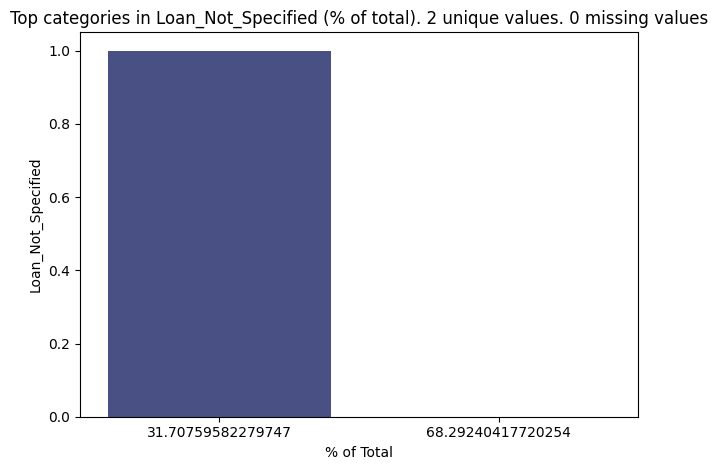

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


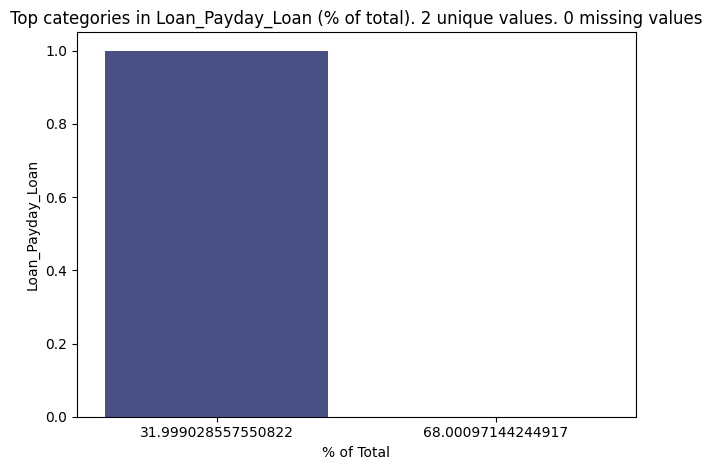

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


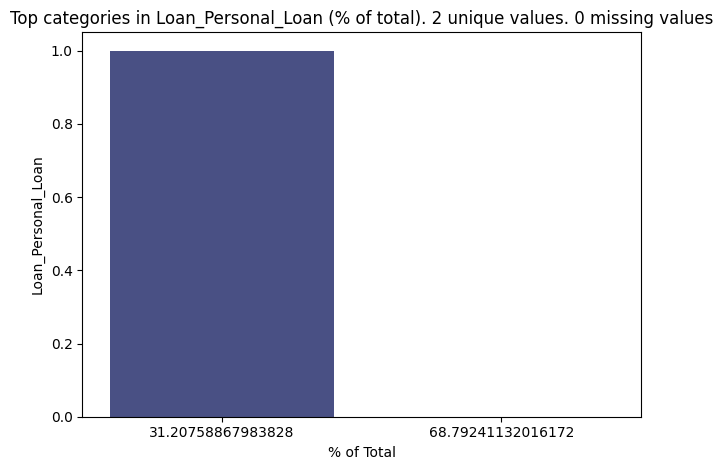

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


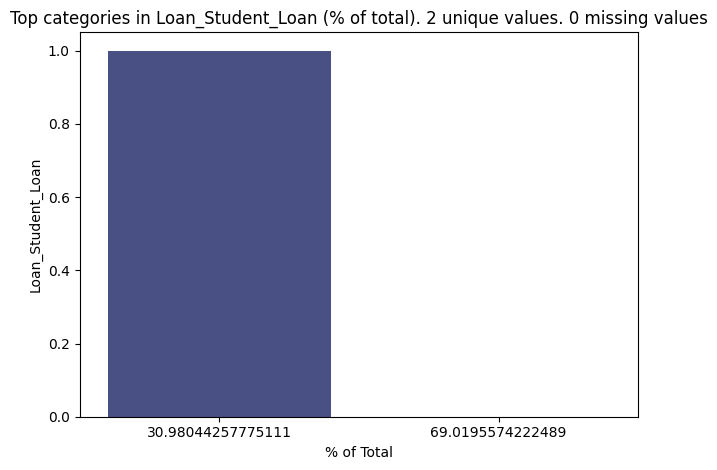

count    6.436400e+04
mean     6.032433e-02
std      8.744071e-02
min      4.086800e-07
50%      2.791091e-02
95%      2.442694e-01
99%      4.467288e-01
max      6.832516e-01
Name: DTI, dtype: float64


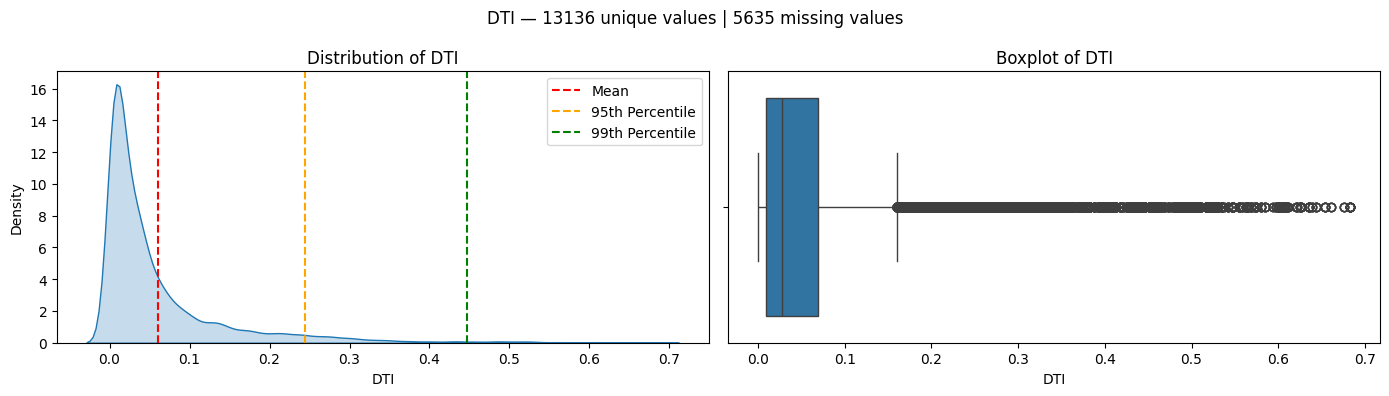

count    59438.000000
mean         0.598190
std          5.096062
min          0.000000
50%          0.025371
95%          0.099581
99%         17.537390
max        227.739318
Name: EMI_Ratio, dtype: float64


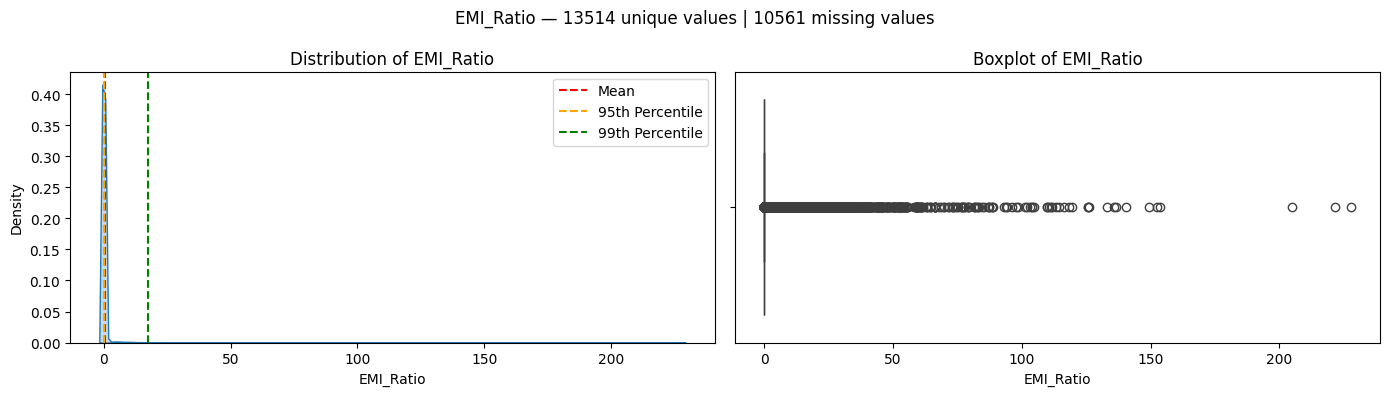

count    69288.000000
mean         6.852583
std          1.083280
min          0.207014
50%          7.064930
95%          8.312803
99%          8.477570
max          8.517007
Name: log_OutDebt, dtype: float64


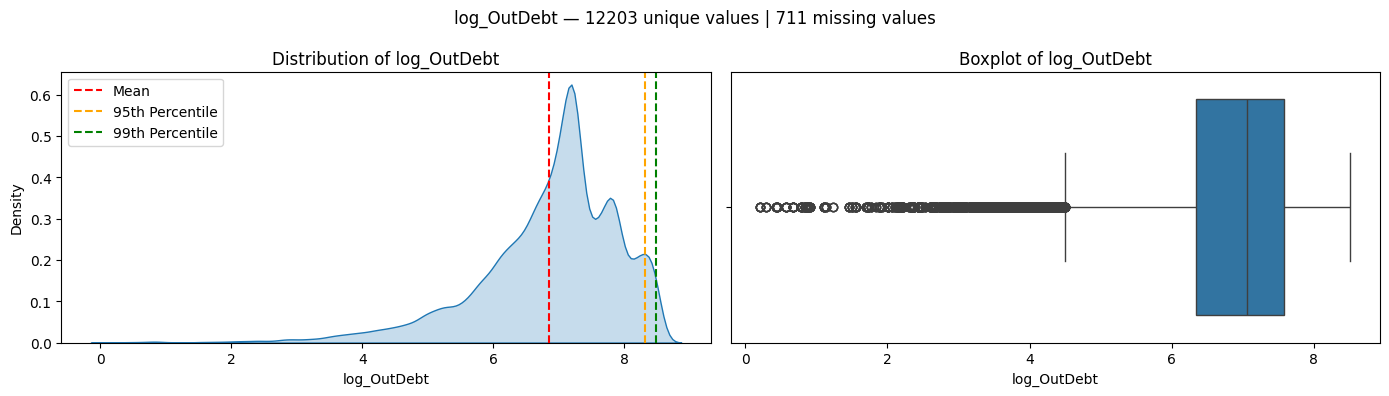

count    65023.000000
mean        10.589442
std          0.963965
min          8.854655
50%         10.531247
95%         11.808876
99%         12.100433
max         17.001783
Name: log_AnnIncome, dtype: float64


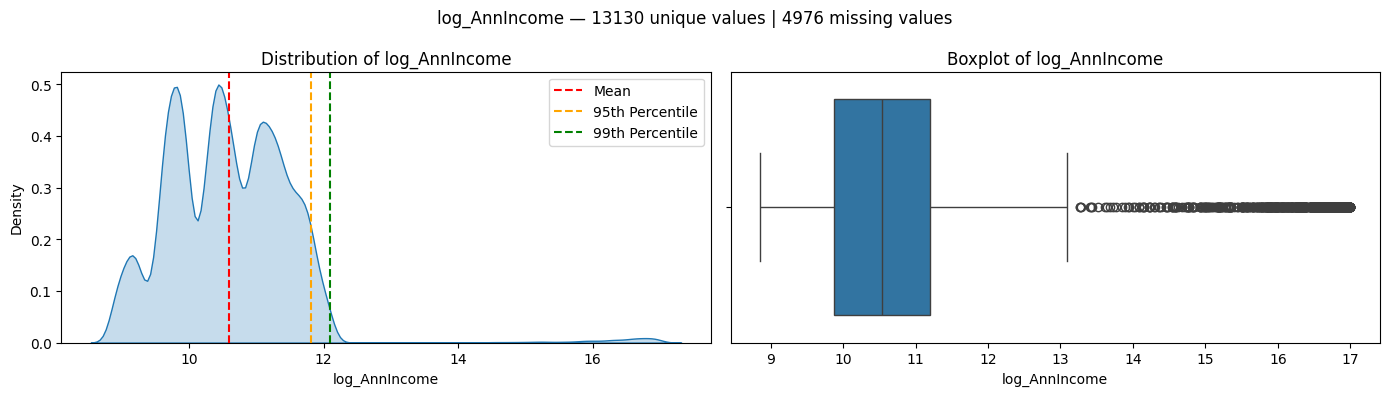

count    69999.000000
mean         4.102110
std          1.956805
min          0.000000
50%          4.252290
95%          6.071951
99%         10.927505
max         11.317604
Name: log_EMI, dtype: float64


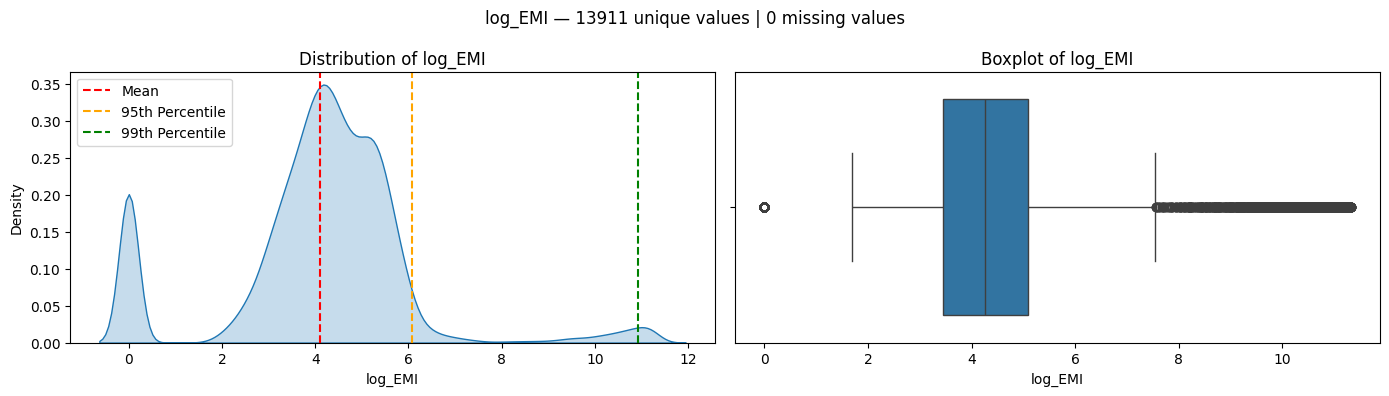

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


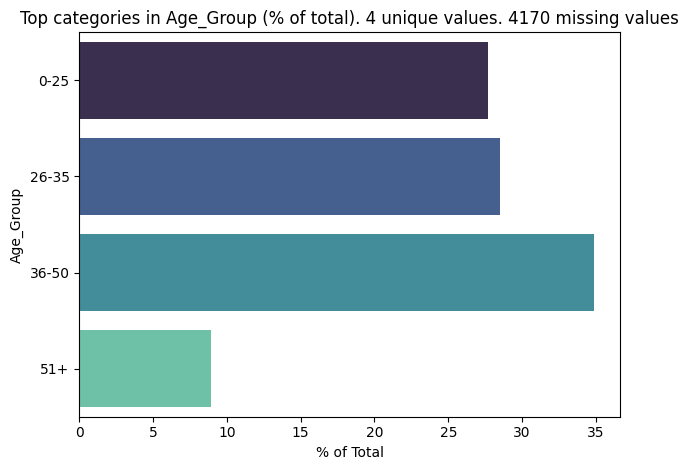

count    65023.000000
mean         2.499146
std          1.117499
min          1.000000
50%          2.000000
95%          4.000000
99%          4.000000
max          4.000000
Name: Income_Quartile, dtype: float64


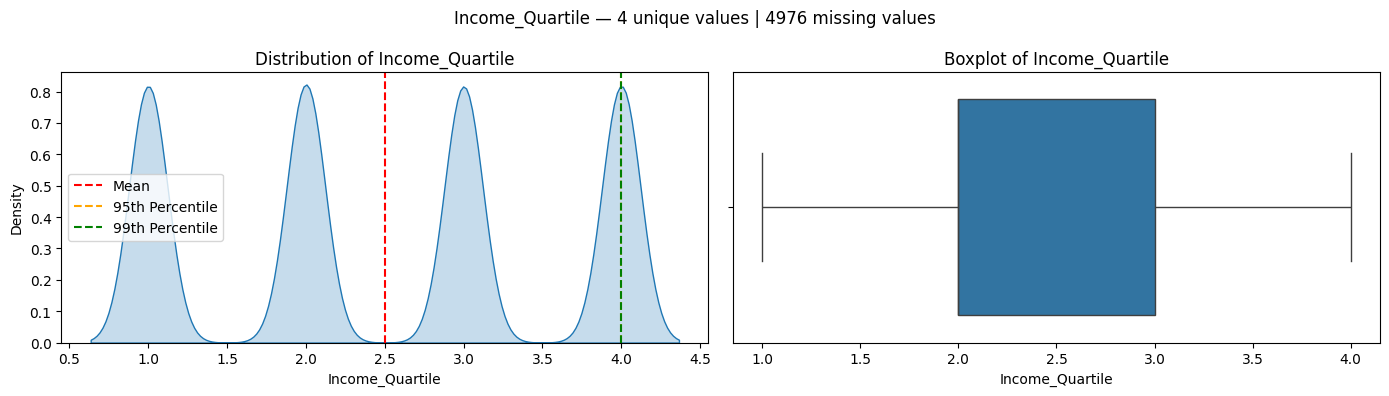

C:\Users\desou\AppData\Local\Temp\ipykernel_14312\628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


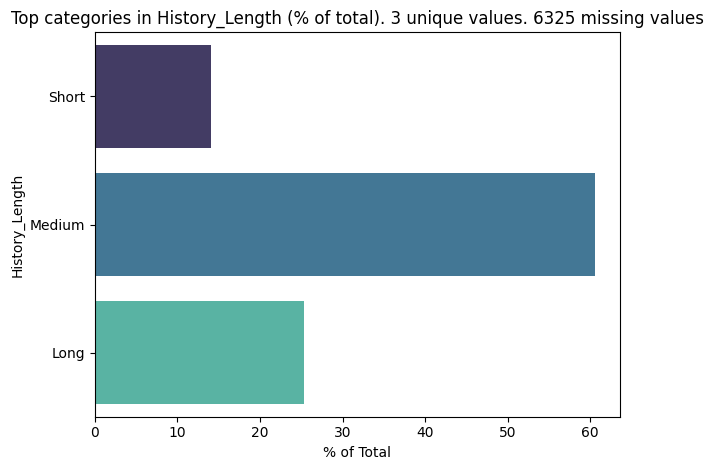

In [232]:

X_train_copy = X_train.copy()
data_to_visualize = DataCleaning(cleaning_rules).fit_transform(X_train_copy)

for variable in data_to_visualize.columns:

    num_unique = data_to_visualize[variable].nunique()
    num_missing = data_to_visualize[variable].isnull().sum()

    if data_to_visualize[variable].dtype in ['float64', 'int64'] and variable not in dummies:
        summary_stats = data_to_visualize[variable].describe(percentiles=[0.95, 0.99]).transpose()
        print(summary_stats)
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sns.kdeplot(data=data_to_visualize, x=variable, ax=axes[0], fill=True)
        axes[0].axvline(mean, color='red', linestyle='--', label='Mean')
        axes[0].axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        axes[0].axvline(p99, color='green', linestyle='--', label='99th Percentile')
        axes[0].set_title(f'Distribution of {variable}')
        axes[0].set_xlabel(variable)
        axes[0].set_ylabel('Density')
        axes[0].legend()

        # Boxplot
        sns.boxplot(data=data_to_visualize, x=variable, ax=axes[1], orient='h')
        axes[1].set_title(f'Boxplot of {variable}')
        axes[1].set_xlabel(variable)

        fig.suptitle(f'{variable} — {num_unique} unique values | {num_missing} missing values', fontsize=12)
        plt.tight_layout()
        plt.show()



    elif variable in dummies:
        # Calculate percentage distribution
        value_counts = data_to_visualize[variable].value_counts(normalize=True) * 100

        # Ensure both 0 and 1 are present in the index
        value_counts = value_counts.reindex([0, 1], fill_value=0)

        # Create the plot
        plt.figure(figsize=(8, 4))
        sns.barplot(x=[0, 1], y=value_counts.values, palette='mako')

        # Customize the plot
        plt.title(f'Distribution of {variable} (Dummy Variable)')
        plt.xlabel(variable)
        plt.ylabel('Percentage (%)')

        # Add percentage labels on top of bars
        for i, v in enumerate(value_counts.values):
            plt.text(i, v + 1, f'{v:.1f}%', ha='center')

        plt.xticks([0, 1], ['0', '1'])  # Explicitly set x-ticks

        plt.tight_layout()
        plt.show()


    elif data_to_visualize[variable].dtype not in ['float64', 'int64'] and data_to_visualize[variable].nunique() <= 20:
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    elif data_to_visualize[variable].dtype not in ['float64', 'int64']:
        # Calculate percentage distribution for all categories
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    


In [233]:
models = {
    'logistic_regression': {
        'estimator': LogisticRegression(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear'],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__max_iter': [100, 200, 500]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'decision_tree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'parameter_grid': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': True,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'random_forest': {
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__max_features': ['sqrt'],
            'classifier__bootstrap': [True],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'gradient_boosting': {
        'estimator': GradientBoostingClassifier(random_state=42),
        'parameter_grid': {
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 3],
            'classifier__subsample': [0.8, 1.0],
            'classifier__max_features': ['sqrt', 0.8]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'xgboost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
        'parameter_grid': {
            'classifier__n_estimators': [100, 300],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__min_child_weight': [1, 5],
            'classifier__subsample': [0.8],
            'classifier__colsample_bytree': [0.8],
            'classifier__scale_pos_weight': [1, 5]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': True
    },
    'lightgbm': {
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__num_leaves': [31, 50],
            'classifier__max_depth': [3, 5],
            'classifier__min_data_in_leaf': [50, 100],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__feature_fraction': [0.8, 1.0],
            'classifier__bagging_fraction': [0.8],
            'classifier__bagging_freq': [3]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'catboost': {
        'estimator': CatBoostClassifier(random_state=42),
        'parameter_grid': {
            'classifier__iterations': [300, 500],
            'classifier__learning_rate': [0.03, 0.05],
            'classifier__depth': [4, 6],
            'classifier__l2_leaf_reg': [3, 5],
            'classifier__bagging_temperature': [0.5, 1.0],
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'knn': {
        'estimator': KNeighborsClassifier(n_jobs=-1),
        'parameter_grid': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['distance'],
            'classifier__metric': ['minkowski', 'manhattan'],
            'classifier__p': [1, 2]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'neural_network': {
        'estimator': MLPClassifier(
            early_stopping=True,
            random_state=42
        ),
        'parameter_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'classifier__solver': ['adam', 'sgd', 'lbfgs'],
            'classifier__alpha': np.linspace(1e-5, 1e-2, 5),
            'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True
    }
}

In [234]:
def create_pipeline(model_config, cleaning_rules):
    pipeline_terms = []

    # Data cleaning
    data_cleaning_transformer = DataCleaning(cleaning_rules)
    pipeline_terms.append(('data_cleaning', data_cleaning_transformer))
    
    # Numeric steps (imputation + scaling)
    numeric_steps = [('imputer', SimpleImputer(strategy='median'))]
    if models[model_config]['scaling'] or models[model_config]['smotenc']:
        numeric_steps.append(('scaler', StandardScaler()))
    numeric_transformer = Pipeline(steps=numeric_steps)

    # Nominal steps (imputation + encoding)
    nominal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        nominal_steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
    nominal_transformer = Pipeline(steps=nominal_steps)

    # Ordinal steps (imputation + encoding)
    ordinal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        ordinal_steps.append(('ordinal', OrdinalEncoder(categories=ordinal_categories, dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)))
    ordinal_transformer = Pipeline(steps=ordinal_steps)

    # Column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('nominal', nominal_transformer, nominal_features),
            ('ordinal', ordinal_transformer, ordinal_features)
        ],
        remainder='passthrough'
    )

    pipeline_terms.append(('preprocessor', preprocessor))
    
    # If SMOTENC is enabled, add it as a separate step
    if models[model_config]['smotenc']:
        cat_len = len(nominal_features) + len(ordinal_features)
        categorical_indices = list(range(len(numerical_features), len(numerical_features) + cat_len))
        pipeline_terms.append(('smotenc', SMOTENC(categorical_features=categorical_indices, random_state=42)))
    
    # Classifier
    pipeline_terms.append(('classifier', models[model_config]['estimator']))
    
    return ImbPipeline(steps=pipeline_terms)

In [235]:
# Running the different models

results = {}

for model_config in models:
    print(f"Running model: {model_config}")

    pipeline = create_pipeline(model_config, cleaning_rules)

    min_res = 2000
    max_attempts = 10
    success = False

    for attempt in range(max_attempts):
        try:
            search = HalvingRandomSearchCV(
                estimator=pipeline,
                param_distributions=models[model_config]['parameter_grid'],
                resource='n_samples',
                factor=5,
                min_resources=min_res,
                n_candidates=20,
                random_state=42,
                verbose=1,
                scoring='f1_macro',
                n_jobs=-1,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            )
            search.fit(X_train, y_train)
            success = True
            break
        except ValueError as e:
            if "n_neighbors" in str(e):
                print(f"min_resources={min_res} failed due to SMOTE. Increasing.")
                min_res += 100
            else:
                raise e


    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    best_model_data = {
        'model': model_config,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score
    }

    results[model_config] = best_model_data


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='best_score', ascending=False)

Running model: logistic_regression
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


Running model: decision_tree
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Running model: random_forest
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Running model: gradient_boosting
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running model: xgboost
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:15:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running model: lightgbm
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 3
n_resources: 10000
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Running model: neural_network
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [236]:
results_df.head(10)

,model,best_model,best_params,best_score
random_forest,random_forest,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__n_estimators': 100, 'classifier_...",0.664413
lightgbm,lightgbm,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__num_leaves': 31, 'classifier__n_...",0.658029
xgboost,xgboost,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__subsample': 0.8, 'classifier__sc...",0.657471
gradient_boosting,gradient_boosting,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__subsample': 0.8, 'classifier__n_...",0.657145
catboost,catboost,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__learning_rate': 0.05, 'classifie...",0.655530
decision_tree,decision_tree,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__min_samples_split': 5, 'classifi...",0.653541
neural_network,neural_network,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__solver': 'sgd', 'classifier__lea...",0.626783
knn,knn,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__weights': 'distance', 'classifie...",0.615082
logistic_regression,logistic_regression,(DataCleaning(cleaning_rules={'Age': {'all_val...,"{'classifier__solver': 'liblinear', 'classifie...",0.611761


In [237]:
from sklearn.metrics import classification_report

# Store validation results
validation_results = {}

for model_name, model_data in results.items():
    best_model = model_data['best_model']

    # Make predictions on the validation set
    y_val_pred = best_model.predict(X_val)

    # Generate classification report
    report_dict = classification_report(y_val, y_val_pred, output_dict=True)
    f1_macro_val = report_dict['macro avg']['f1-score']

    validation_results[model_name] = {
        'classification_report': report_dict,
        'f1_macro_val': f1_macro_val,
        'model': best_model
    }

# Convert to DataFrame for sorting
val_results_df = pd.DataFrame([
    {
        'model_name': name,
        'f1_macro_val': data['f1_macro_val'],
        'classification_report': data['classification_report'],
        'model': data['model']
    }
    for name, data in validation_results.items()
])

# Sort by f1_macro in descending order
val_results_df = val_results_df.sort_values(by='f1_macro_val', ascending=False)

# Display the sorted results
val_results_df.head(10)


c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,model_name,f1_macro_val,classification_report,model
7,knn,0.768521,"{'0': {'precision': 0.7547169811320755, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
6,catboost,0.698371,"{'0': {'precision': 0.7541884816753927, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
4,xgboost,0.691032,"{'0': {'precision': 0.7520595269731597, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
3,gradient_boosting,0.690123,"{'0': {'precision': 0.7583040777747773, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
5,lightgbm,0.686153,"{'0': {'precision': 0.7570960698689956, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
8,neural_network,0.674997,"{'0': {'precision': 0.6965842167255595, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
1,decision_tree,0.668956,"{'0': {'precision': 0.6768759571209801, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
2,random_forest,0.666854,"{'0': {'precision': 0.6442105263157895, 'recal...",(DataCleaning(cleaning_rules={'Age': {'all_val...
0,logistic_regression,0.614367,"{'0': {'precision': 0.656484727090636, 'recall...",(DataCleaning(cleaning_rules={'Age': {'all_val...


              precision    recall  f1-score   support

           0       0.66      0.60      0.63      4350
           1       0.69      0.69      0.69      7977
           2       0.50      0.56      0.53      2674

    accuracy                           0.64     15001
   macro avg       0.61      0.62      0.61     15001
weighted avg       0.64      0.64      0.64     15001



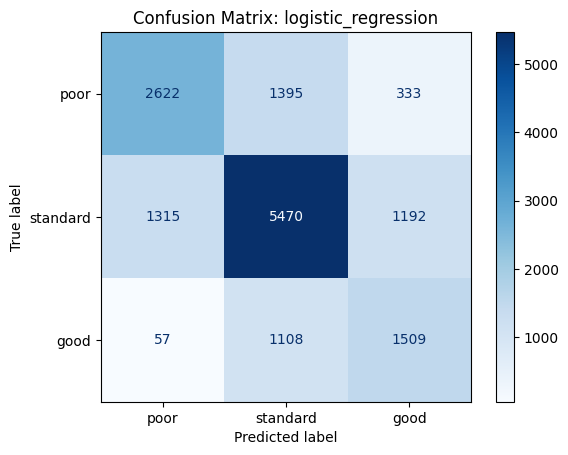

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      4350
           1       0.79      0.63      0.70      7977
           2       0.51      0.76      0.61      2674

    accuracy                           0.68     15001
   macro avg       0.66      0.70      0.67     15001
weighted avg       0.71      0.68      0.68     15001



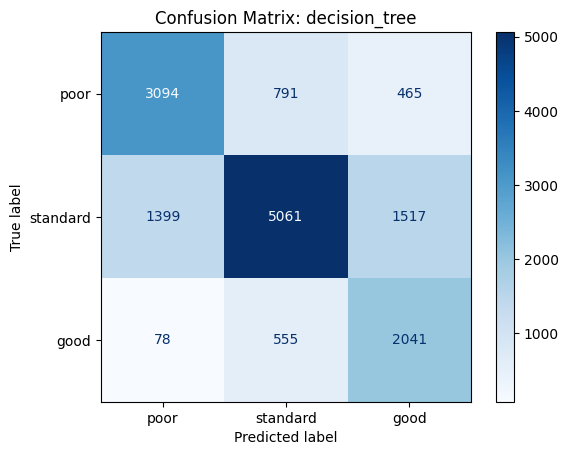

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      4350
           1       0.86      0.56      0.68      7977
           2       0.49      0.84      0.62      2674

    accuracy                           0.67     15001
   macro avg       0.66      0.72      0.67     15001
weighted avg       0.73      0.67      0.68     15001



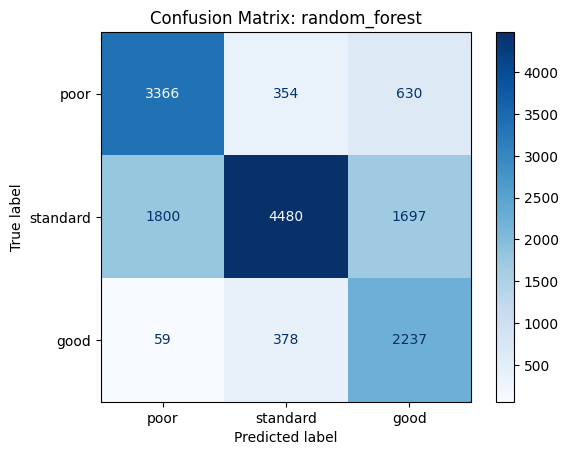

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      4350
           1       0.74      0.76      0.75      7977
           2       0.58      0.66      0.62      2674

    accuracy                           0.71     15001
   macro avg       0.69      0.69      0.69     15001
weighted avg       0.72      0.71      0.71     15001



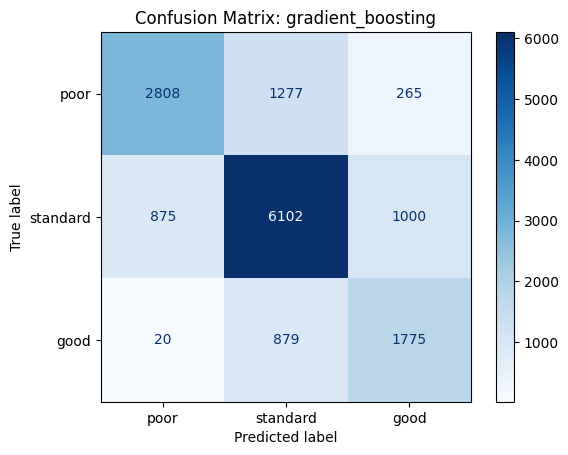

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      4350
           1       0.74      0.77      0.75      7977
           2       0.59      0.66      0.62      2674

    accuracy                           0.71     15001
   macro avg       0.69      0.69      0.69     15001
weighted avg       0.72      0.71      0.71     15001



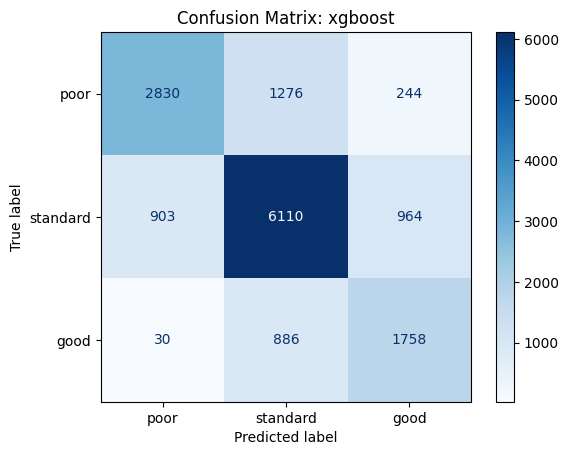

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
              precision    recall  f1-score   support

           0       0.76      0.64      0.69      4350
           1       0.74      0.76      0.75      7977
           2       0.58      0.66      0.62      2674

    accuracy                           0.71     15001
   macro avg       0.69      0.69      0.69     15001
weighted avg       0.71      0.71      0.71     15001



c:\Users\desou\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


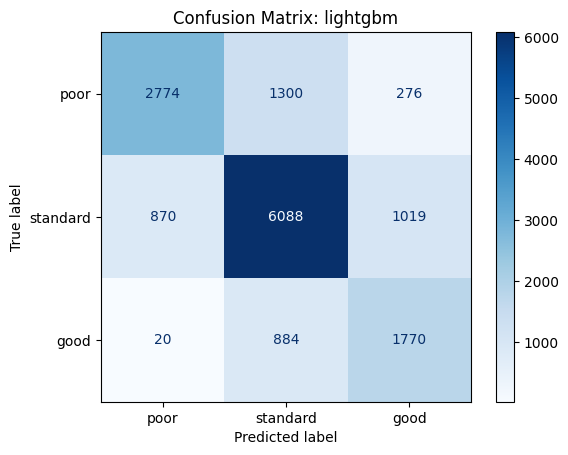

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      4350
           1       0.75      0.78      0.76      7977
           2       0.61      0.65      0.63      2674

    accuracy                           0.72     15001
   macro avg       0.70      0.70      0.70     15001
weighted avg       0.72      0.72      0.72     15001



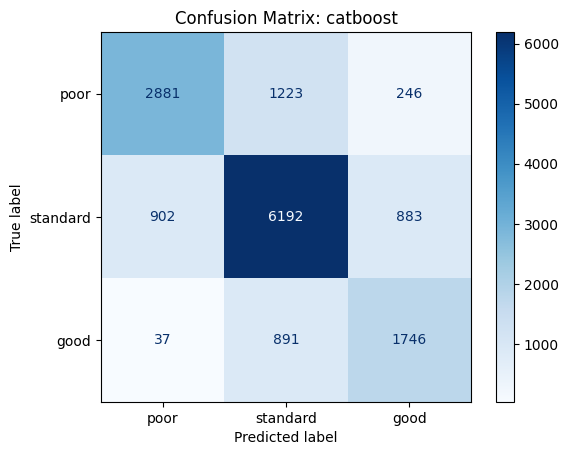

              precision    recall  f1-score   support

           0       0.75      0.86      0.81      4350
           1       0.88      0.69      0.77      7977
           2       0.62      0.87      0.73      2674

    accuracy                           0.77     15001
   macro avg       0.75      0.81      0.77     15001
weighted avg       0.80      0.77      0.77     15001



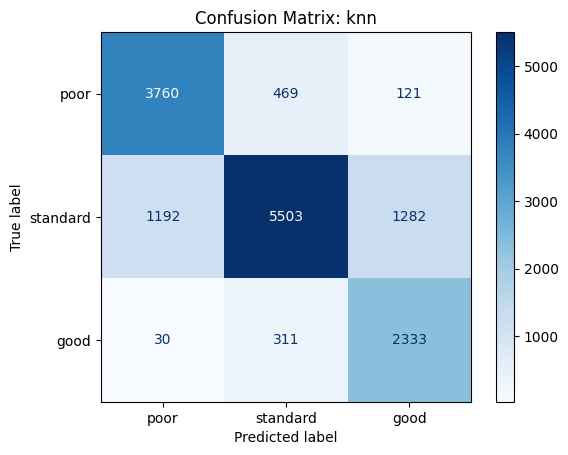

              precision    recall  f1-score   support

           0       0.70      0.68      0.69      4350
           1       0.75      0.70      0.73      7977
           2       0.55      0.68      0.61      2674

    accuracy                           0.69     15001
   macro avg       0.67      0.69      0.67     15001
weighted avg       0.70      0.69      0.69     15001



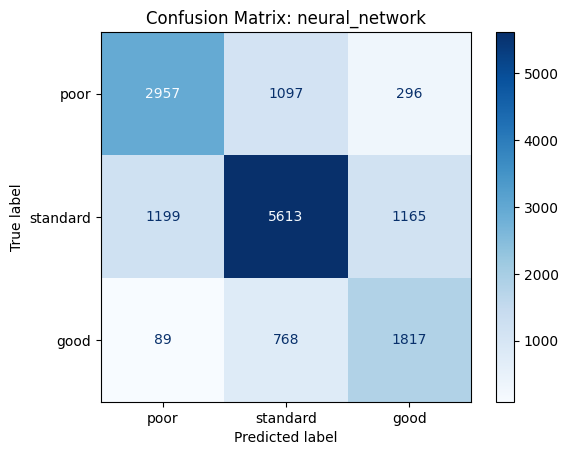

In [238]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_labels = ['poor', 'standard', 'good']

# Evaluate and plot confusion matrix for each best model
for model_name, model_data in results.items():
    best_model = model_data['best_model']
    
    # Predict on the test set
    y_val_pred = best_model.predict(X_val)

    print(classification_report(y_val, y_val_pred))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()


In [ ]:
# Get the best model (top row in the sorted table)
best_model_row = val_results_df.iloc[0]
best_model_name = best_model_row['model_name']
best_model_pipeline = best_model_row['model']

best_model = best_model_pipeline.fit(X_train_val, y_train_val)

In [192]:
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)
report_str = classification_report(y_test, y_test_pred)
print("Classification Report:\n")
print(report_str)

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      4350
           1       0.88      0.70      0.78      7976
           2       0.66      0.88      0.75      2674

    accuracy                           0.78     15000
   macro avg       0.76      0.82      0.78     15000
weighted avg       0.80      0.78      0.78     15000

